#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


## Lab. 05 - Convolutional Autoencoder

An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

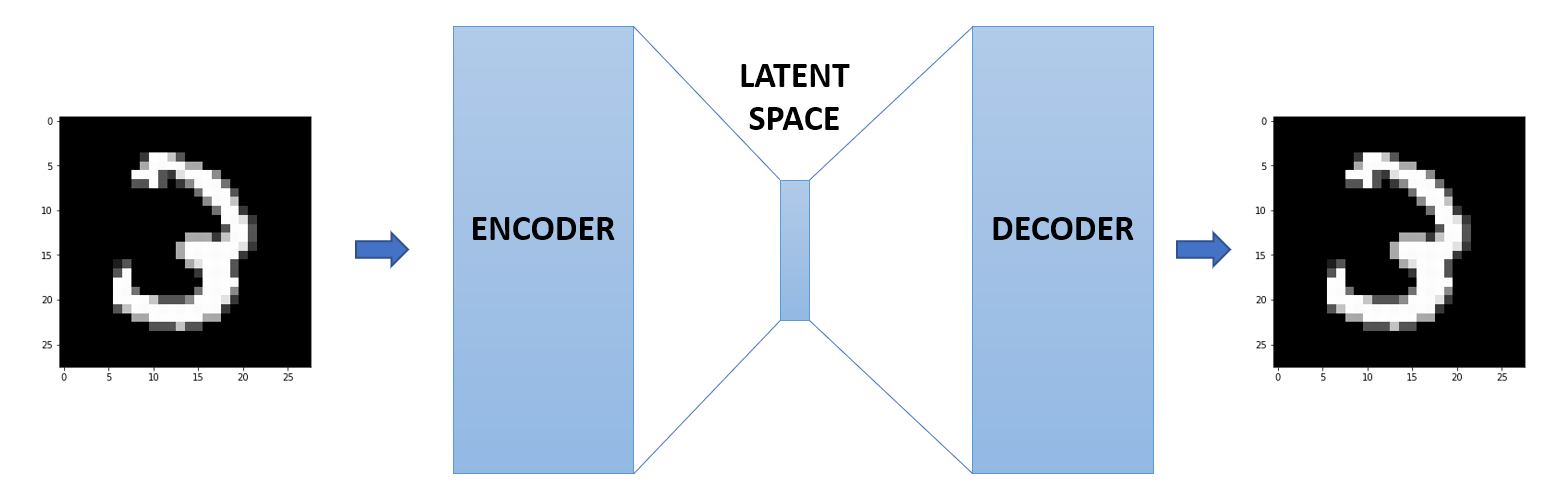

The learning process is described simply as minimizing a loss function $L(x, g(f(x)))$, where $L$ is a loss function penalizing $g(f(x))$ for being dissimilar from $x$, such as the mean squared error.

While the learning is considered to be unsupervised since we are using only the value of $x$, the actual implementation is similar to a supervised setting where the label is just derived from the input.

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Dataset

## Define the dataset

For this lab. we will use one of the dataset already included in PyTorch ([https://pytorch.org/docs/stable/torchvision/datasets.html#mnist](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)). These dataset do not require the definition of a custom `Dataset` class, so we can focus on the network implementation.

The MNIST dataset is a colletion of hand-written digits. The size of the images is $28 \times 28$, and there is a single channel only (black and white images).

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

The output of the dataset is a PIL Image, a standard format for image processing, but we can easily convert the data to a numpy array:
```
image_numpy = np.array(pil_image)
```
or to a PyTorch tensor:
```
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(pil_image)
```


Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

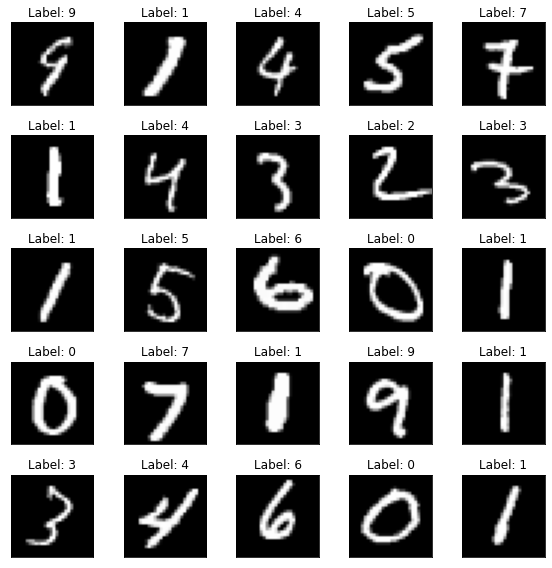

In [3]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [4]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


Since we already defined our datasets, this is an alternative (and recommended) way to add (or modify) a dataset transformation without reinitializing the dataset (very useful when the dataset initialization is slow):

In [5]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [6]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

## Encoder

Let's start from the encoder. In the figure you can find a suggested architecture for the encoder, with all the required parameters for each layer.

In this example we are considering a latent space with just **2 variables**, so make sure your encoder generates tensors with the proper shape.

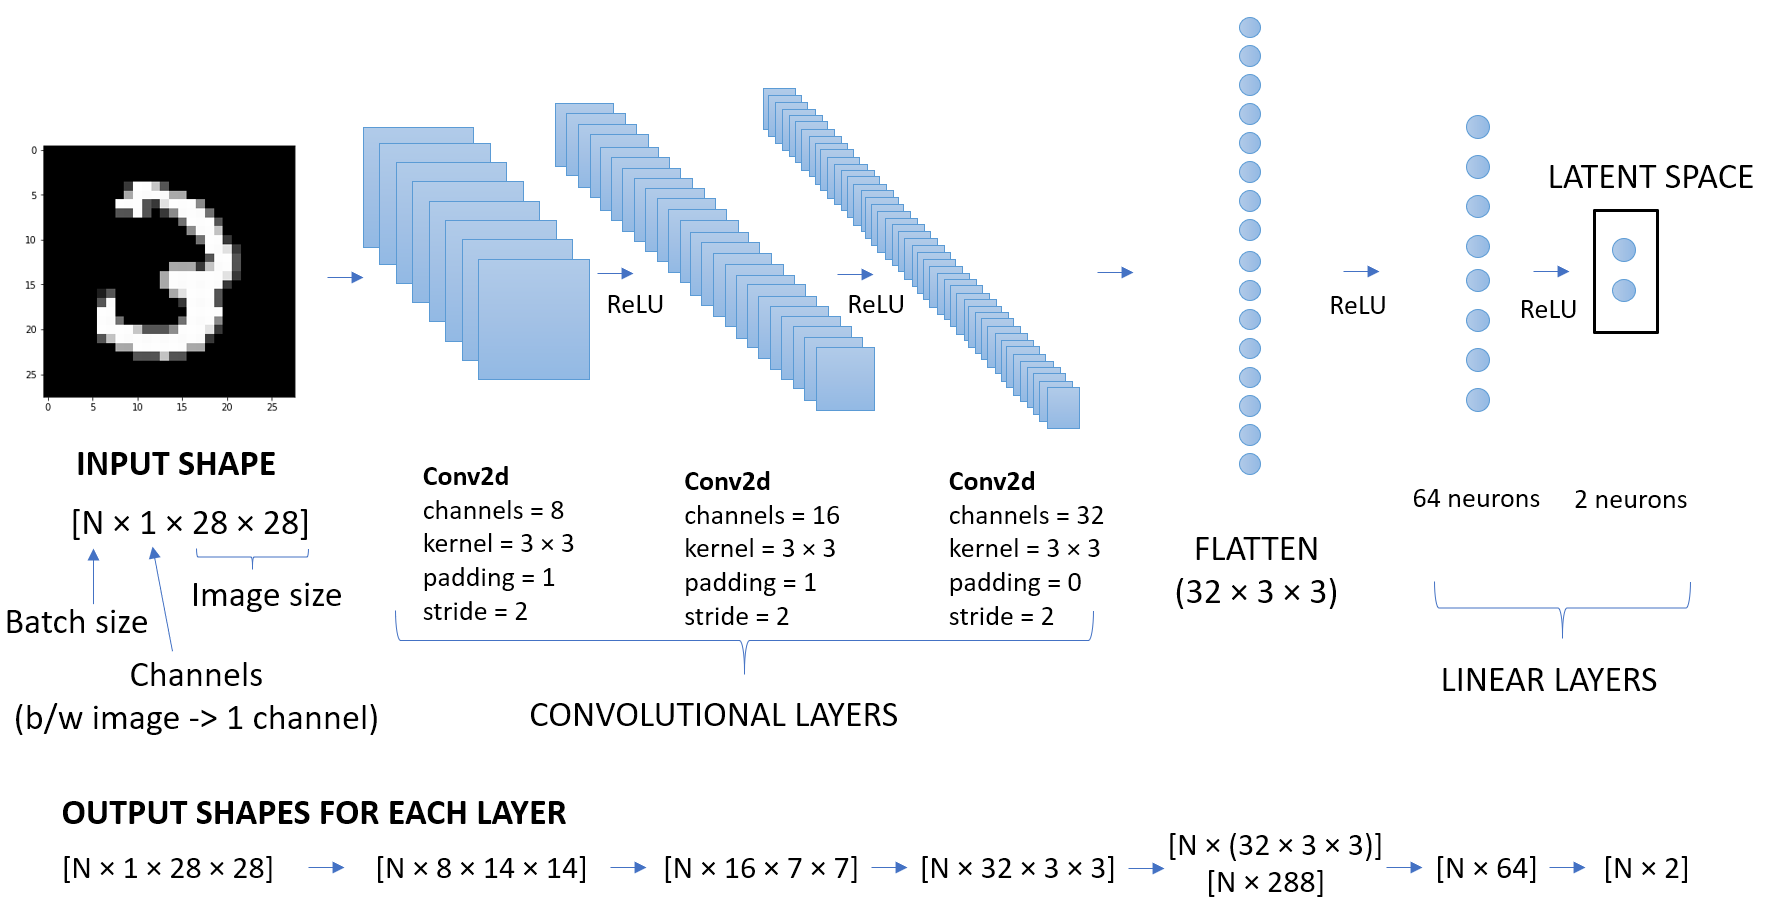

`torch.nn.Sequential` is a utility function that allows to easily concatenate sequential layers, without defining a separate object for each of them (more details here: [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)).

The output of a convolutional layer is typically multi-dimensional. To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array. This operation is often referred to as **flattening**. In PyTorch, this can be done with the [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten)
 layer. By setting `start_dim = 1` we keep the first axis (index 0) as it is (which represents the batch size in our case, that should not be flattened) and all the other axes will be flattened in the new second axis.


In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)#dimension 0 is the sample, so we flatten from dimension 1

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## Decoder

Typically the structure of the decoder is specular with respect to the encoder, but this is not a strict requirement. Some successfull implementations use very different architectures for the encoder and the decoder. 

The only requirement of the decoder is the input shape, which must match the latent space, and the output shape, that must match the input image. 

In this example we implement a decoder perfectly matched with the encoder architecture, but reversed.

Since the convolutional layers in the encoder perform a down-scaling, we need up-scaling layers in the decoder. To this end we use **transposed convolutions**, already available in PyTorch with the [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layer.

Similarly to the `torch.nn.Flatten` layer, the [`torch.nn.Unflatten`](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html?highlight=unflatten#torch.nn.Unflatten) layer does the opposite operation. We take the axis at index 1 (`dim=1`) and we reshape it to the proper shape (`unflattened_size=(32, 3, 3)`).

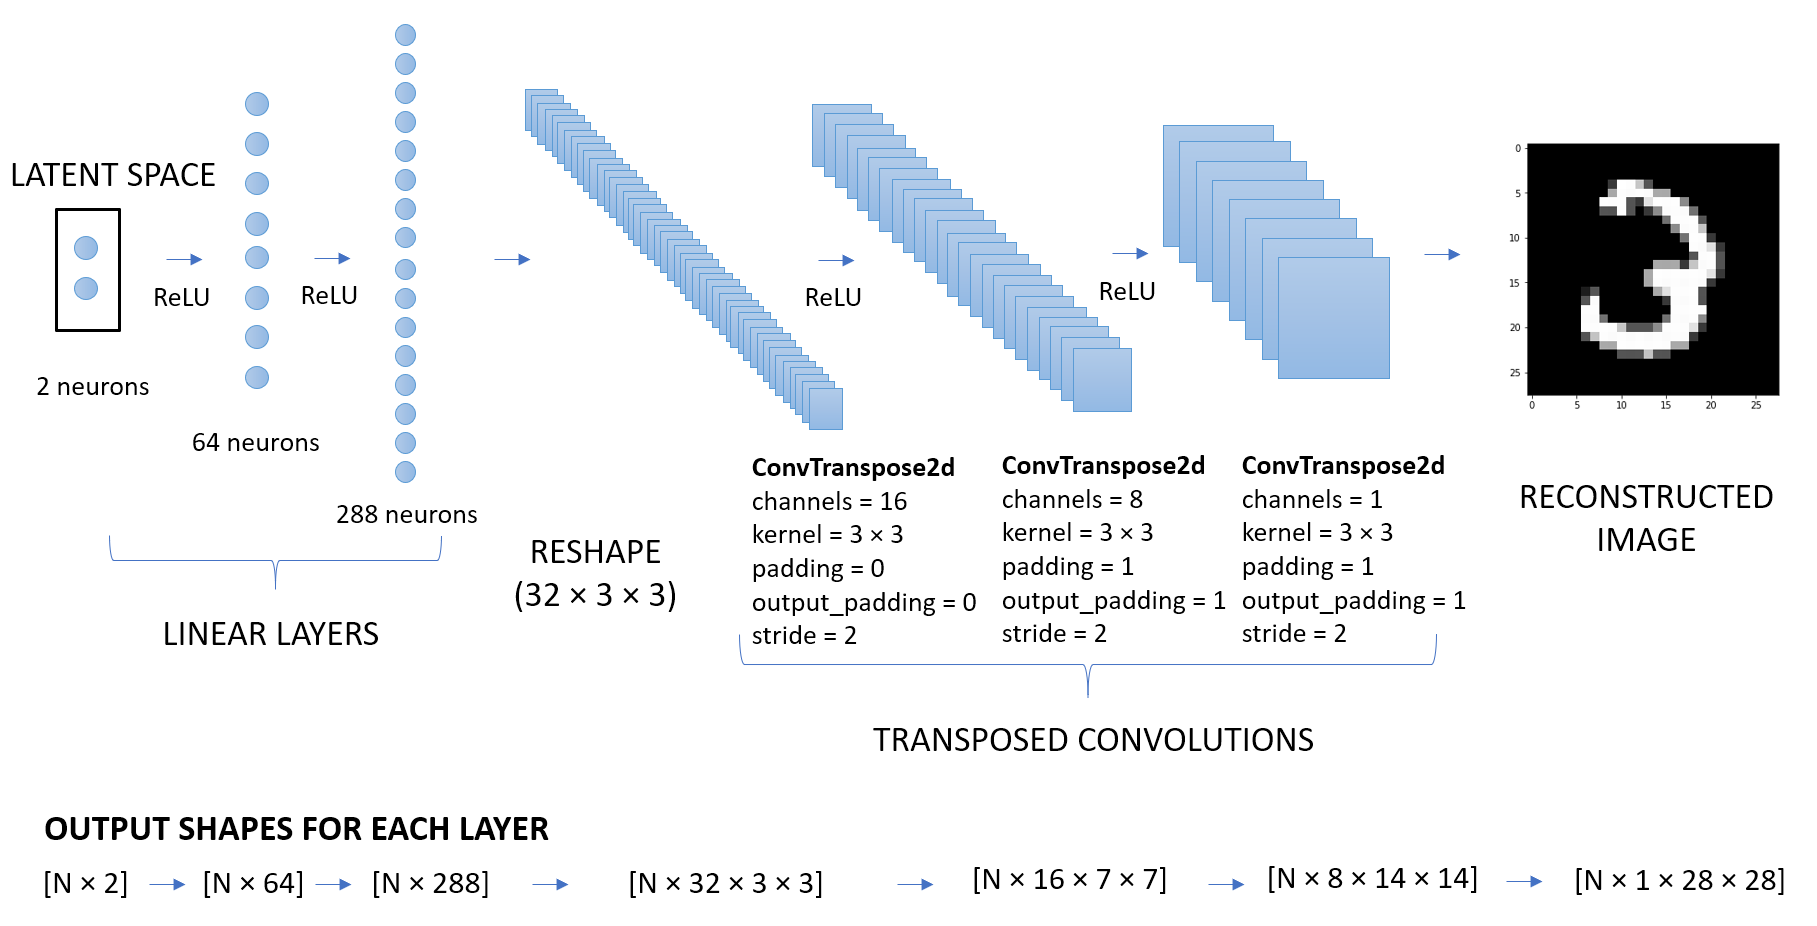

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [10]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


# Training

The training is similar to the previous examples. The only difference is that now we have 2 different networks. In this situation you have 2 choices:
*   Use a single optimizer to train the parameters of both networks.
*   Define a separate optimizer for each network, and update both of them in the trainin cycle.

In this case we define a single optimizer for both networks, by just providing a list of the required parameters to the optimizer (see the code below).

You can find more details for all the possible scenarios [here](https://pytorch.org/docs/stable/optim.html).

In [11]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

For a cleaner and more reusable code, we define a training and a testing funcion. This will make the training loop more compact and readable.

The function will train (and test) the network just **for a single epoch**.

In this case, we just track the training loss for each batch. If you want the training loss for the entire epoch, you have to concatenate all the outputs (see the testing function as reference for this case).

In [12]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))

## Testing function

In this case, the testing function has the only goal to evaluate how well we are reproducing the input. We quantify this with the average MSE of the entire test set (which in this case correspond to our loss function, but this is not always true).

Since the entire dataset does not always fit in memory, this example shows how to evaluate the network output in batches, aggregating the results (using `conc_out` and `conc_label` in the code). At the end, you can evaluate a  single overall loss.

In [13]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

Now that we have the training and testing functions, the training loop is considerably simplified. We just need to call these 2 functions for `num_epochs` times.

To see what happen during the training, we also show the output corresponding to a specific image at the end of each epoch.

EPOCH 1/40
	 partial train loss (single batch): 0.247023
	 partial train loss (single batch): 0.246403
	 partial train loss (single batch): 0.245999
	 partial train loss (single batch): 0.244965
	 partial train loss (single batch): 0.243749
	 partial train loss (single batch): 0.243320
	 partial train loss (single batch): 0.242649
	 partial train loss (single batch): 0.240978
	 partial train loss (single batch): 0.240743
	 partial train loss (single batch): 0.240488
	 partial train loss (single batch): 0.239288
	 partial train loss (single batch): 0.237986
	 partial train loss (single batch): 0.236657
	 partial train loss (single batch): 0.235354
	 partial train loss (single batch): 0.234254
	 partial train loss (single batch): 0.233354
	 partial train loss (single batch): 0.231408
	 partial train loss (single batch): 0.230341
	 partial train loss (single batch): 0.228596
	 partial train loss (single batch): 0.226815
	 partial train loss (single batch): 0.224675
	 partial train loss (s

	 partial train loss (single batch): 0.065250
	 partial train loss (single batch): 0.065635
	 partial train loss (single batch): 0.066138
	 partial train loss (single batch): 0.064279
	 partial train loss (single batch): 0.065091
	 partial train loss (single batch): 0.065946
	 partial train loss (single batch): 0.065018
	 partial train loss (single batch): 0.064053
	 partial train loss (single batch): 0.066202
	 partial train loss (single batch): 0.064618
	 partial train loss (single batch): 0.063667
	 partial train loss (single batch): 0.066500
	 partial train loss (single batch): 0.064339
	 partial train loss (single batch): 0.065621
	 partial train loss (single batch): 0.066139
	 partial train loss (single batch): 0.064289
	 partial train loss (single batch): 0.063159
	 partial train loss (single batch): 0.063895
	 partial train loss (single batch): 0.065352
	 partial train loss (single batch): 0.063480
	 partial train loss (single batch): 0.064899
	 partial train loss (single batch

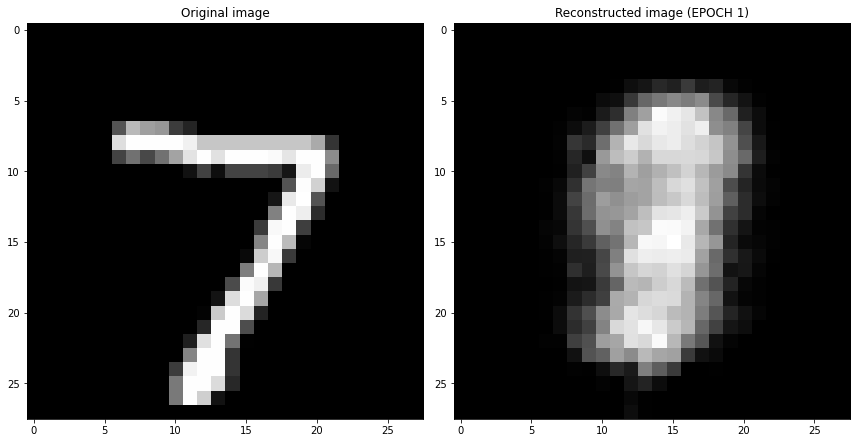

EPOCH 2/40
	 partial train loss (single batch): 0.062386
	 partial train loss (single batch): 0.063094
	 partial train loss (single batch): 0.064159
	 partial train loss (single batch): 0.063914
	 partial train loss (single batch): 0.061776
	 partial train loss (single batch): 0.061748
	 partial train loss (single batch): 0.059579
	 partial train loss (single batch): 0.061592
	 partial train loss (single batch): 0.061351
	 partial train loss (single batch): 0.061948
	 partial train loss (single batch): 0.061746
	 partial train loss (single batch): 0.060644
	 partial train loss (single batch): 0.061653
	 partial train loss (single batch): 0.061105
	 partial train loss (single batch): 0.061546
	 partial train loss (single batch): 0.063053
	 partial train loss (single batch): 0.061592
	 partial train loss (single batch): 0.061650
	 partial train loss (single batch): 0.062616
	 partial train loss (single batch): 0.062366
	 partial train loss (single batch): 0.060684
	 partial train loss (s

	 partial train loss (single batch): 0.057463
	 partial train loss (single batch): 0.059155
	 partial train loss (single batch): 0.056339
	 partial train loss (single batch): 0.057501
	 partial train loss (single batch): 0.057266
	 partial train loss (single batch): 0.058254
	 partial train loss (single batch): 0.056286
	 partial train loss (single batch): 0.058966
	 partial train loss (single batch): 0.056135
	 partial train loss (single batch): 0.058497
	 partial train loss (single batch): 0.059291
	 partial train loss (single batch): 0.055078
	 partial train loss (single batch): 0.057627
	 partial train loss (single batch): 0.058417
	 partial train loss (single batch): 0.059488
	 partial train loss (single batch): 0.056940
	 partial train loss (single batch): 0.057338
	 partial train loss (single batch): 0.057731
	 partial train loss (single batch): 0.056671
	 partial train loss (single batch): 0.058411
	 partial train loss (single batch): 0.057032
	 partial train loss (single batch

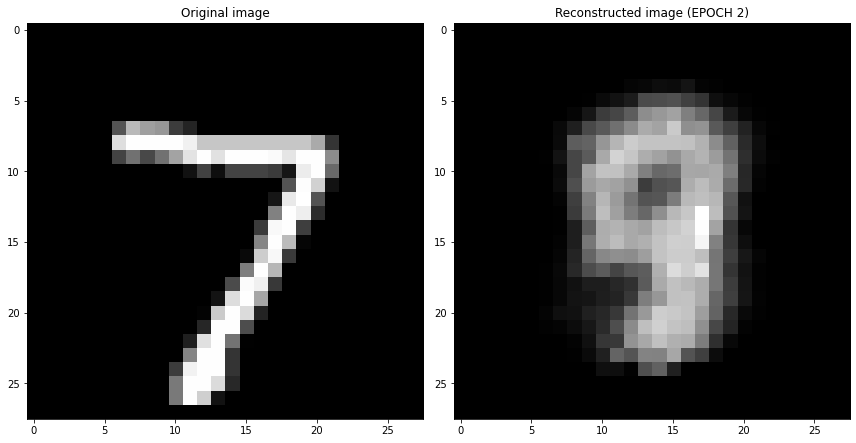

EPOCH 3/40
	 partial train loss (single batch): 0.054456
	 partial train loss (single batch): 0.057483
	 partial train loss (single batch): 0.056629
	 partial train loss (single batch): 0.056415
	 partial train loss (single batch): 0.057591
	 partial train loss (single batch): 0.059379
	 partial train loss (single batch): 0.056158
	 partial train loss (single batch): 0.055894
	 partial train loss (single batch): 0.056866
	 partial train loss (single batch): 0.056743
	 partial train loss (single batch): 0.055433
	 partial train loss (single batch): 0.054554
	 partial train loss (single batch): 0.055403
	 partial train loss (single batch): 0.056551
	 partial train loss (single batch): 0.057994
	 partial train loss (single batch): 0.057019
	 partial train loss (single batch): 0.055674
	 partial train loss (single batch): 0.054909
	 partial train loss (single batch): 0.057475
	 partial train loss (single batch): 0.056231
	 partial train loss (single batch): 0.056966
	 partial train loss (s

	 partial train loss (single batch): 0.054376
	 partial train loss (single batch): 0.056136
	 partial train loss (single batch): 0.055496
	 partial train loss (single batch): 0.053667
	 partial train loss (single batch): 0.054225
	 partial train loss (single batch): 0.054348
	 partial train loss (single batch): 0.054292
	 partial train loss (single batch): 0.055356
	 partial train loss (single batch): 0.054899
	 partial train loss (single batch): 0.055480
	 partial train loss (single batch): 0.056329
	 partial train loss (single batch): 0.053096
	 partial train loss (single batch): 0.055555
	 partial train loss (single batch): 0.054250
	 partial train loss (single batch): 0.053965
	 partial train loss (single batch): 0.054394
	 partial train loss (single batch): 0.054722
	 partial train loss (single batch): 0.055202
	 partial train loss (single batch): 0.053769
	 partial train loss (single batch): 0.055726
	 partial train loss (single batch): 0.053962
	 partial train loss (single batch

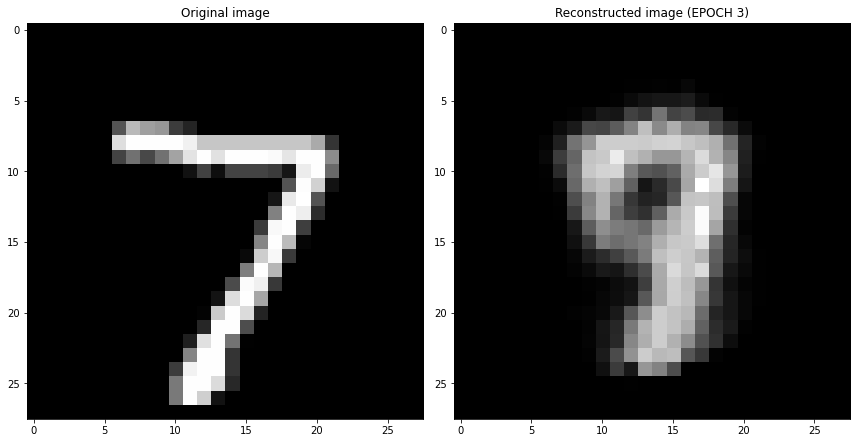

EPOCH 4/40
	 partial train loss (single batch): 0.054166
	 partial train loss (single batch): 0.055807
	 partial train loss (single batch): 0.055631
	 partial train loss (single batch): 0.054001
	 partial train loss (single batch): 0.053776
	 partial train loss (single batch): 0.054982
	 partial train loss (single batch): 0.054322
	 partial train loss (single batch): 0.054552
	 partial train loss (single batch): 0.053613
	 partial train loss (single batch): 0.056283
	 partial train loss (single batch): 0.056583
	 partial train loss (single batch): 0.053892
	 partial train loss (single batch): 0.052115
	 partial train loss (single batch): 0.055780
	 partial train loss (single batch): 0.054690
	 partial train loss (single batch): 0.052744
	 partial train loss (single batch): 0.052854
	 partial train loss (single batch): 0.054873
	 partial train loss (single batch): 0.053582
	 partial train loss (single batch): 0.054740
	 partial train loss (single batch): 0.053137
	 partial train loss (s

	 partial train loss (single batch): 0.052744
	 partial train loss (single batch): 0.052251
	 partial train loss (single batch): 0.054069
	 partial train loss (single batch): 0.050927
	 partial train loss (single batch): 0.052139
	 partial train loss (single batch): 0.051729
	 partial train loss (single batch): 0.054171
	 partial train loss (single batch): 0.052403
	 partial train loss (single batch): 0.050938
	 partial train loss (single batch): 0.053391
	 partial train loss (single batch): 0.051836
	 partial train loss (single batch): 0.050050
	 partial train loss (single batch): 0.053590
	 partial train loss (single batch): 0.051349
	 partial train loss (single batch): 0.051449
	 partial train loss (single batch): 0.051382
	 partial train loss (single batch): 0.052467
	 partial train loss (single batch): 0.053517
	 partial train loss (single batch): 0.053859
	 partial train loss (single batch): 0.052533
	 partial train loss (single batch): 0.052771
	 partial train loss (single batch

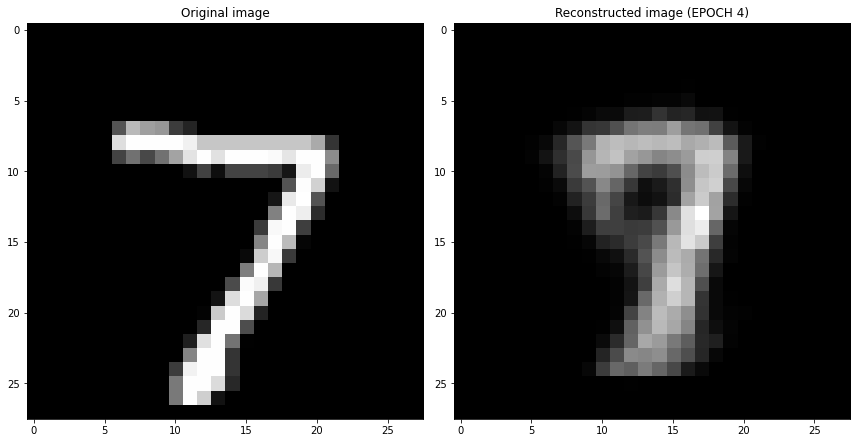

EPOCH 5/40
	 partial train loss (single batch): 0.050926
	 partial train loss (single batch): 0.052446
	 partial train loss (single batch): 0.052513
	 partial train loss (single batch): 0.053145
	 partial train loss (single batch): 0.052971
	 partial train loss (single batch): 0.052479
	 partial train loss (single batch): 0.049793
	 partial train loss (single batch): 0.052428
	 partial train loss (single batch): 0.050618
	 partial train loss (single batch): 0.051781
	 partial train loss (single batch): 0.052091
	 partial train loss (single batch): 0.051903
	 partial train loss (single batch): 0.052341
	 partial train loss (single batch): 0.052081
	 partial train loss (single batch): 0.051626
	 partial train loss (single batch): 0.050187
	 partial train loss (single batch): 0.052151
	 partial train loss (single batch): 0.054796
	 partial train loss (single batch): 0.053108
	 partial train loss (single batch): 0.050827
	 partial train loss (single batch): 0.052970
	 partial train loss (s

	 partial train loss (single batch): 0.050155
	 partial train loss (single batch): 0.050020
	 partial train loss (single batch): 0.050715
	 partial train loss (single batch): 0.048492
	 partial train loss (single batch): 0.051568
	 partial train loss (single batch): 0.052468
	 partial train loss (single batch): 0.049925
	 partial train loss (single batch): 0.049660
	 partial train loss (single batch): 0.050582
	 partial train loss (single batch): 0.052049
	 partial train loss (single batch): 0.050471
	 partial train loss (single batch): 0.049711
	 partial train loss (single batch): 0.051491
	 partial train loss (single batch): 0.051812
	 partial train loss (single batch): 0.050113
	 partial train loss (single batch): 0.050183
	 partial train loss (single batch): 0.051306
	 partial train loss (single batch): 0.047786
	 partial train loss (single batch): 0.052495
	 partial train loss (single batch): 0.050590
	 partial train loss (single batch): 0.051097
	 partial train loss (single batch

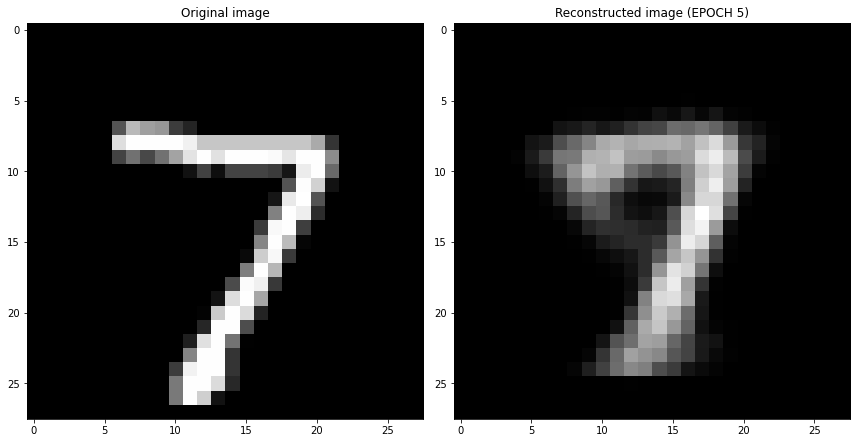

EPOCH 6/40
	 partial train loss (single batch): 0.048401
	 partial train loss (single batch): 0.050041
	 partial train loss (single batch): 0.049992
	 partial train loss (single batch): 0.049137
	 partial train loss (single batch): 0.050489
	 partial train loss (single batch): 0.049788
	 partial train loss (single batch): 0.049728
	 partial train loss (single batch): 0.050856
	 partial train loss (single batch): 0.050880
	 partial train loss (single batch): 0.051594
	 partial train loss (single batch): 0.048241
	 partial train loss (single batch): 0.049462
	 partial train loss (single batch): 0.049174
	 partial train loss (single batch): 0.049220
	 partial train loss (single batch): 0.050957
	 partial train loss (single batch): 0.049389
	 partial train loss (single batch): 0.051980
	 partial train loss (single batch): 0.050118
	 partial train loss (single batch): 0.050030
	 partial train loss (single batch): 0.051368
	 partial train loss (single batch): 0.050906
	 partial train loss (s

	 partial train loss (single batch): 0.050130
	 partial train loss (single batch): 0.048332
	 partial train loss (single batch): 0.048583
	 partial train loss (single batch): 0.047503
	 partial train loss (single batch): 0.048305
	 partial train loss (single batch): 0.046805
	 partial train loss (single batch): 0.046952
	 partial train loss (single batch): 0.047998
	 partial train loss (single batch): 0.049445
	 partial train loss (single batch): 0.050171
	 partial train loss (single batch): 0.050267
	 partial train loss (single batch): 0.048484
	 partial train loss (single batch): 0.047595
	 partial train loss (single batch): 0.046286
	 partial train loss (single batch): 0.048348
	 partial train loss (single batch): 0.047087
	 partial train loss (single batch): 0.049696
	 partial train loss (single batch): 0.047612
	 partial train loss (single batch): 0.048217
	 partial train loss (single batch): 0.048333
	 partial train loss (single batch): 0.049713
	 partial train loss (single batch

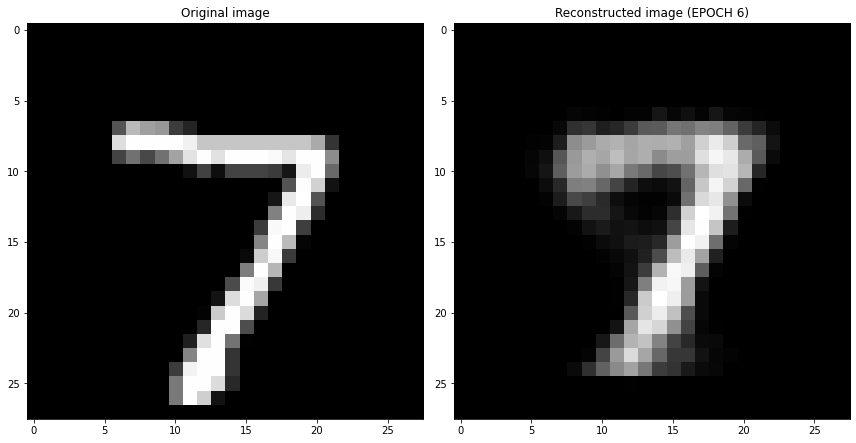

EPOCH 7/40
	 partial train loss (single batch): 0.047293
	 partial train loss (single batch): 0.049890
	 partial train loss (single batch): 0.047662
	 partial train loss (single batch): 0.048469
	 partial train loss (single batch): 0.048608
	 partial train loss (single batch): 0.046910
	 partial train loss (single batch): 0.050102
	 partial train loss (single batch): 0.044640
	 partial train loss (single batch): 0.047451
	 partial train loss (single batch): 0.048264
	 partial train loss (single batch): 0.047720
	 partial train loss (single batch): 0.047273
	 partial train loss (single batch): 0.048963
	 partial train loss (single batch): 0.047256
	 partial train loss (single batch): 0.046682
	 partial train loss (single batch): 0.049331
	 partial train loss (single batch): 0.048524
	 partial train loss (single batch): 0.048774
	 partial train loss (single batch): 0.047574
	 partial train loss (single batch): 0.050319
	 partial train loss (single batch): 0.047896
	 partial train loss (s

	 partial train loss (single batch): 0.045632
	 partial train loss (single batch): 0.048321
	 partial train loss (single batch): 0.048294
	 partial train loss (single batch): 0.046116
	 partial train loss (single batch): 0.048668
	 partial train loss (single batch): 0.046142
	 partial train loss (single batch): 0.045216
	 partial train loss (single batch): 0.043462
	 partial train loss (single batch): 0.045910
	 partial train loss (single batch): 0.048853
	 partial train loss (single batch): 0.046551
	 partial train loss (single batch): 0.043514
	 partial train loss (single batch): 0.046791
	 partial train loss (single batch): 0.049954
	 partial train loss (single batch): 0.047819
	 partial train loss (single batch): 0.047698
	 partial train loss (single batch): 0.049077
	 partial train loss (single batch): 0.047900
	 partial train loss (single batch): 0.045947
	 partial train loss (single batch): 0.047516
	 partial train loss (single batch): 0.047559
	 partial train loss (single batch

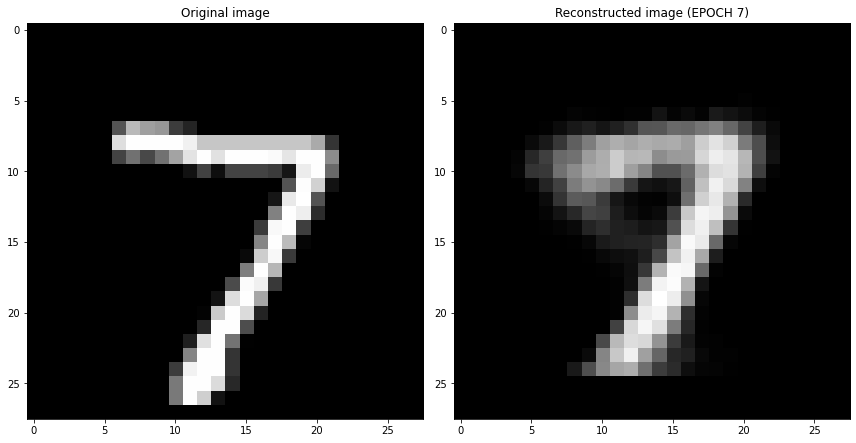

EPOCH 8/40
	 partial train loss (single batch): 0.048439
	 partial train loss (single batch): 0.045362
	 partial train loss (single batch): 0.044631
	 partial train loss (single batch): 0.045025
	 partial train loss (single batch): 0.046270
	 partial train loss (single batch): 0.045780
	 partial train loss (single batch): 0.045784
	 partial train loss (single batch): 0.047002
	 partial train loss (single batch): 0.047013
	 partial train loss (single batch): 0.046470
	 partial train loss (single batch): 0.048978
	 partial train loss (single batch): 0.048074
	 partial train loss (single batch): 0.046640
	 partial train loss (single batch): 0.046577
	 partial train loss (single batch): 0.046641
	 partial train loss (single batch): 0.047528
	 partial train loss (single batch): 0.046295
	 partial train loss (single batch): 0.046264
	 partial train loss (single batch): 0.046579
	 partial train loss (single batch): 0.046740
	 partial train loss (single batch): 0.045458
	 partial train loss (s

	 partial train loss (single batch): 0.045731
	 partial train loss (single batch): 0.045014
	 partial train loss (single batch): 0.047846
	 partial train loss (single batch): 0.045157
	 partial train loss (single batch): 0.044846
	 partial train loss (single batch): 0.044009
	 partial train loss (single batch): 0.047926
	 partial train loss (single batch): 0.048874
	 partial train loss (single batch): 0.044466
	 partial train loss (single batch): 0.043892
	 partial train loss (single batch): 0.044986
	 partial train loss (single batch): 0.044557
	 partial train loss (single batch): 0.046436
	 partial train loss (single batch): 0.043959
	 partial train loss (single batch): 0.047138
	 partial train loss (single batch): 0.047180
	 partial train loss (single batch): 0.045320
	 partial train loss (single batch): 0.046541
	 partial train loss (single batch): 0.046398
	 partial train loss (single batch): 0.047704
	 partial train loss (single batch): 0.044445
	 partial train loss (single batch

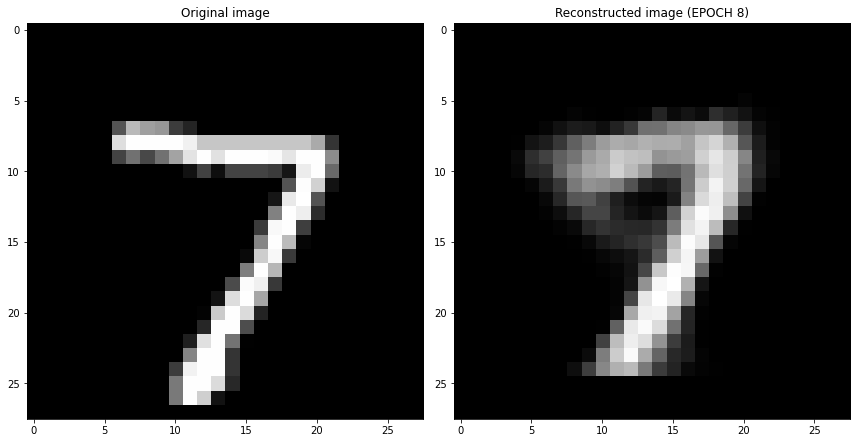

EPOCH 9/40
	 partial train loss (single batch): 0.046076
	 partial train loss (single batch): 0.044608
	 partial train loss (single batch): 0.047005
	 partial train loss (single batch): 0.044788
	 partial train loss (single batch): 0.046039
	 partial train loss (single batch): 0.046194
	 partial train loss (single batch): 0.045918
	 partial train loss (single batch): 0.045367
	 partial train loss (single batch): 0.041150
	 partial train loss (single batch): 0.044462
	 partial train loss (single batch): 0.047114
	 partial train loss (single batch): 0.046301
	 partial train loss (single batch): 0.046649
	 partial train loss (single batch): 0.046375
	 partial train loss (single batch): 0.044525
	 partial train loss (single batch): 0.045616
	 partial train loss (single batch): 0.045420
	 partial train loss (single batch): 0.044945
	 partial train loss (single batch): 0.045980
	 partial train loss (single batch): 0.045279
	 partial train loss (single batch): 0.045118
	 partial train loss (s

	 partial train loss (single batch): 0.045832
	 partial train loss (single batch): 0.044804
	 partial train loss (single batch): 0.044853
	 partial train loss (single batch): 0.045341
	 partial train loss (single batch): 0.046391
	 partial train loss (single batch): 0.045449
	 partial train loss (single batch): 0.045042
	 partial train loss (single batch): 0.045106
	 partial train loss (single batch): 0.044709
	 partial train loss (single batch): 0.043199
	 partial train loss (single batch): 0.048342
	 partial train loss (single batch): 0.043306
	 partial train loss (single batch): 0.045296
	 partial train loss (single batch): 0.046008
	 partial train loss (single batch): 0.046316
	 partial train loss (single batch): 0.044286
	 partial train loss (single batch): 0.043297
	 partial train loss (single batch): 0.045276
	 partial train loss (single batch): 0.046830
	 partial train loss (single batch): 0.045276
	 partial train loss (single batch): 0.044626
	 partial train loss (single batch

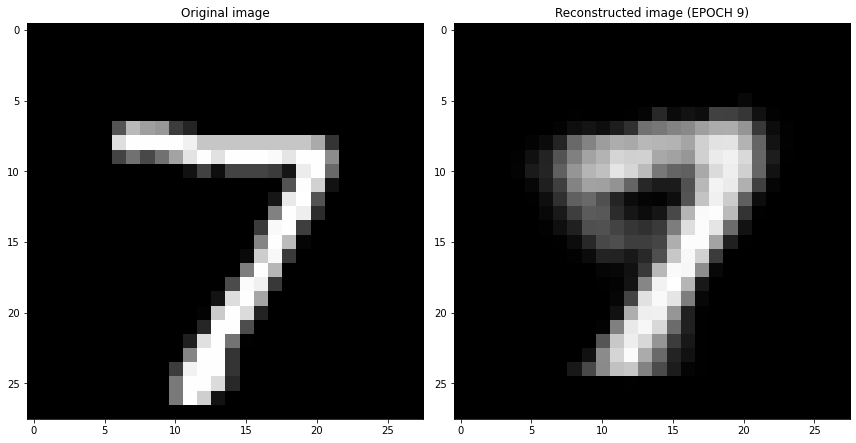

EPOCH 10/40
	 partial train loss (single batch): 0.046444
	 partial train loss (single batch): 0.046643
	 partial train loss (single batch): 0.046142
	 partial train loss (single batch): 0.044482
	 partial train loss (single batch): 0.043961
	 partial train loss (single batch): 0.043588
	 partial train loss (single batch): 0.043075
	 partial train loss (single batch): 0.044864
	 partial train loss (single batch): 0.044956
	 partial train loss (single batch): 0.045369
	 partial train loss (single batch): 0.045980
	 partial train loss (single batch): 0.042674
	 partial train loss (single batch): 0.043487
	 partial train loss (single batch): 0.045253
	 partial train loss (single batch): 0.044716
	 partial train loss (single batch): 0.045063
	 partial train loss (single batch): 0.046113
	 partial train loss (single batch): 0.043533
	 partial train loss (single batch): 0.046799
	 partial train loss (single batch): 0.045110
	 partial train loss (single batch): 0.046733
	 partial train loss (

	 partial train loss (single batch): 0.045311
	 partial train loss (single batch): 0.045697
	 partial train loss (single batch): 0.044556
	 partial train loss (single batch): 0.045700
	 partial train loss (single batch): 0.045380
	 partial train loss (single batch): 0.045405
	 partial train loss (single batch): 0.045086
	 partial train loss (single batch): 0.045582
	 partial train loss (single batch): 0.045822
	 partial train loss (single batch): 0.042978
	 partial train loss (single batch): 0.043589
	 partial train loss (single batch): 0.048525
	 partial train loss (single batch): 0.045276
	 partial train loss (single batch): 0.044627
	 partial train loss (single batch): 0.046812
	 partial train loss (single batch): 0.042901
	 partial train loss (single batch): 0.045021
	 partial train loss (single batch): 0.043792
	 partial train loss (single batch): 0.044034
	 partial train loss (single batch): 0.045087
	 partial train loss (single batch): 0.042150
	 partial train loss (single batch

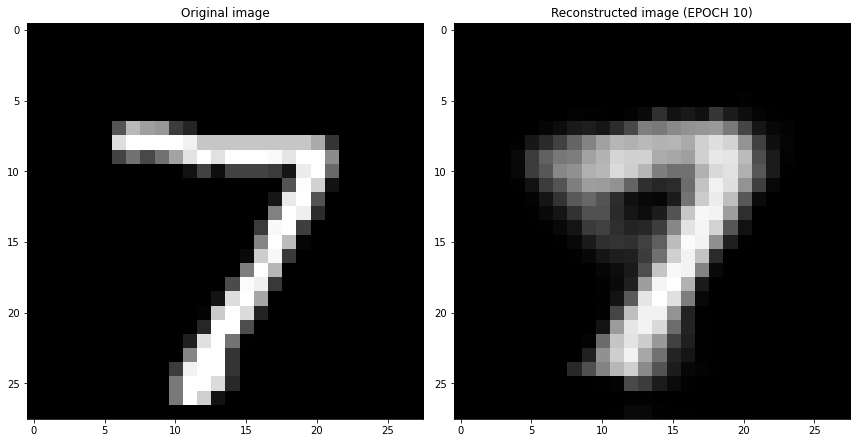

EPOCH 11/40
	 partial train loss (single batch): 0.043497
	 partial train loss (single batch): 0.042195
	 partial train loss (single batch): 0.044643
	 partial train loss (single batch): 0.043698
	 partial train loss (single batch): 0.045390
	 partial train loss (single batch): 0.043617
	 partial train loss (single batch): 0.044721
	 partial train loss (single batch): 0.044343
	 partial train loss (single batch): 0.043731
	 partial train loss (single batch): 0.045205
	 partial train loss (single batch): 0.042774
	 partial train loss (single batch): 0.044456
	 partial train loss (single batch): 0.043617
	 partial train loss (single batch): 0.043231
	 partial train loss (single batch): 0.043749
	 partial train loss (single batch): 0.043352
	 partial train loss (single batch): 0.044594
	 partial train loss (single batch): 0.044026
	 partial train loss (single batch): 0.044791
	 partial train loss (single batch): 0.044087
	 partial train loss (single batch): 0.044053
	 partial train loss (

	 partial train loss (single batch): 0.043968
	 partial train loss (single batch): 0.043256
	 partial train loss (single batch): 0.045298
	 partial train loss (single batch): 0.042806
	 partial train loss (single batch): 0.041953
	 partial train loss (single batch): 0.043970
	 partial train loss (single batch): 0.044526
	 partial train loss (single batch): 0.046817
	 partial train loss (single batch): 0.043562
	 partial train loss (single batch): 0.043290
	 partial train loss (single batch): 0.043454
	 partial train loss (single batch): 0.043441
	 partial train loss (single batch): 0.044421
	 partial train loss (single batch): 0.044182
	 partial train loss (single batch): 0.043599
	 partial train loss (single batch): 0.042954
	 partial train loss (single batch): 0.043652
	 partial train loss (single batch): 0.044219
	 partial train loss (single batch): 0.042746
	 partial train loss (single batch): 0.042539
	 partial train loss (single batch): 0.043563
	 partial train loss (single batch

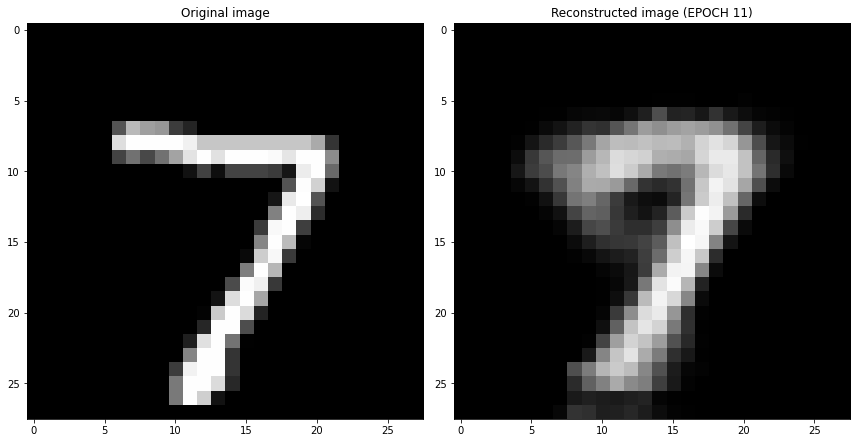

EPOCH 12/40
	 partial train loss (single batch): 0.041388
	 partial train loss (single batch): 0.043895
	 partial train loss (single batch): 0.045518
	 partial train loss (single batch): 0.044559
	 partial train loss (single batch): 0.044810
	 partial train loss (single batch): 0.044638
	 partial train loss (single batch): 0.044361
	 partial train loss (single batch): 0.043214
	 partial train loss (single batch): 0.043279
	 partial train loss (single batch): 0.042010
	 partial train loss (single batch): 0.041182
	 partial train loss (single batch): 0.042591
	 partial train loss (single batch): 0.045766
	 partial train loss (single batch): 0.043707
	 partial train loss (single batch): 0.044735
	 partial train loss (single batch): 0.042041
	 partial train loss (single batch): 0.044922
	 partial train loss (single batch): 0.042539
	 partial train loss (single batch): 0.043368
	 partial train loss (single batch): 0.046147
	 partial train loss (single batch): 0.042787
	 partial train loss (

	 partial train loss (single batch): 0.041576
	 partial train loss (single batch): 0.042814
	 partial train loss (single batch): 0.042378
	 partial train loss (single batch): 0.043025
	 partial train loss (single batch): 0.042459
	 partial train loss (single batch): 0.042460
	 partial train loss (single batch): 0.043361
	 partial train loss (single batch): 0.041300
	 partial train loss (single batch): 0.044659
	 partial train loss (single batch): 0.042342
	 partial train loss (single batch): 0.042993
	 partial train loss (single batch): 0.043338
	 partial train loss (single batch): 0.042078
	 partial train loss (single batch): 0.040775
	 partial train loss (single batch): 0.043609
	 partial train loss (single batch): 0.043383
	 partial train loss (single batch): 0.042910
	 partial train loss (single batch): 0.042584
	 partial train loss (single batch): 0.041028
	 partial train loss (single batch): 0.044715
	 partial train loss (single batch): 0.044341
	 partial train loss (single batch

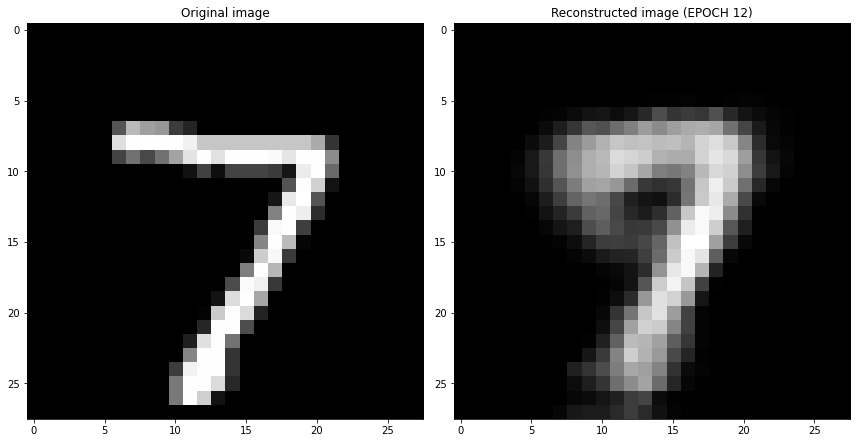

EPOCH 13/40
	 partial train loss (single batch): 0.043213
	 partial train loss (single batch): 0.043599
	 partial train loss (single batch): 0.041140
	 partial train loss (single batch): 0.045271
	 partial train loss (single batch): 0.045556
	 partial train loss (single batch): 0.043576
	 partial train loss (single batch): 0.042168
	 partial train loss (single batch): 0.041236
	 partial train loss (single batch): 0.042364
	 partial train loss (single batch): 0.043391
	 partial train loss (single batch): 0.043521
	 partial train loss (single batch): 0.042662
	 partial train loss (single batch): 0.043131
	 partial train loss (single batch): 0.042341
	 partial train loss (single batch): 0.043051
	 partial train loss (single batch): 0.042394
	 partial train loss (single batch): 0.042796
	 partial train loss (single batch): 0.042343
	 partial train loss (single batch): 0.043126
	 partial train loss (single batch): 0.043195
	 partial train loss (single batch): 0.042885
	 partial train loss (

	 partial train loss (single batch): 0.041852
	 partial train loss (single batch): 0.043149
	 partial train loss (single batch): 0.043965
	 partial train loss (single batch): 0.041785
	 partial train loss (single batch): 0.041771
	 partial train loss (single batch): 0.043575
	 partial train loss (single batch): 0.043497
	 partial train loss (single batch): 0.041672
	 partial train loss (single batch): 0.044583
	 partial train loss (single batch): 0.040344
	 partial train loss (single batch): 0.042074
	 partial train loss (single batch): 0.041702
	 partial train loss (single batch): 0.044451
	 partial train loss (single batch): 0.042046
	 partial train loss (single batch): 0.042006
	 partial train loss (single batch): 0.043587
	 partial train loss (single batch): 0.041951
	 partial train loss (single batch): 0.042435
	 partial train loss (single batch): 0.042647
	 partial train loss (single batch): 0.042609
	 partial train loss (single batch): 0.044140
	 partial train loss (single batch

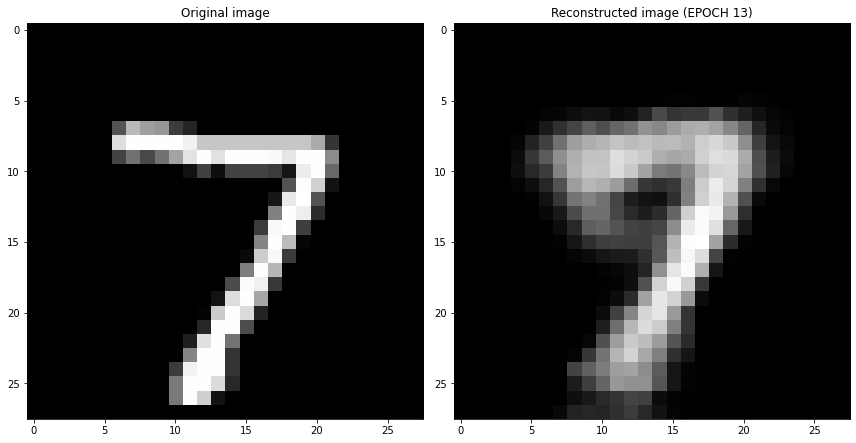

EPOCH 14/40
	 partial train loss (single batch): 0.042551
	 partial train loss (single batch): 0.043000
	 partial train loss (single batch): 0.041810
	 partial train loss (single batch): 0.042055
	 partial train loss (single batch): 0.043507
	 partial train loss (single batch): 0.041407
	 partial train loss (single batch): 0.040576
	 partial train loss (single batch): 0.042740
	 partial train loss (single batch): 0.043532
	 partial train loss (single batch): 0.044849
	 partial train loss (single batch): 0.042686
	 partial train loss (single batch): 0.042010
	 partial train loss (single batch): 0.043001
	 partial train loss (single batch): 0.043127
	 partial train loss (single batch): 0.041211
	 partial train loss (single batch): 0.042215
	 partial train loss (single batch): 0.042695
	 partial train loss (single batch): 0.042123
	 partial train loss (single batch): 0.042954
	 partial train loss (single batch): 0.043093
	 partial train loss (single batch): 0.042074
	 partial train loss (

	 partial train loss (single batch): 0.041827
	 partial train loss (single batch): 0.042154
	 partial train loss (single batch): 0.041876
	 partial train loss (single batch): 0.041491
	 partial train loss (single batch): 0.041634
	 partial train loss (single batch): 0.042683
	 partial train loss (single batch): 0.042358
	 partial train loss (single batch): 0.042299
	 partial train loss (single batch): 0.041563
	 partial train loss (single batch): 0.041742
	 partial train loss (single batch): 0.041091
	 partial train loss (single batch): 0.043977
	 partial train loss (single batch): 0.040232
	 partial train loss (single batch): 0.041103
	 partial train loss (single batch): 0.043145
	 partial train loss (single batch): 0.040760
	 partial train loss (single batch): 0.042805
	 partial train loss (single batch): 0.042387
	 partial train loss (single batch): 0.041665
	 partial train loss (single batch): 0.041983
	 partial train loss (single batch): 0.041813
	 partial train loss (single batch

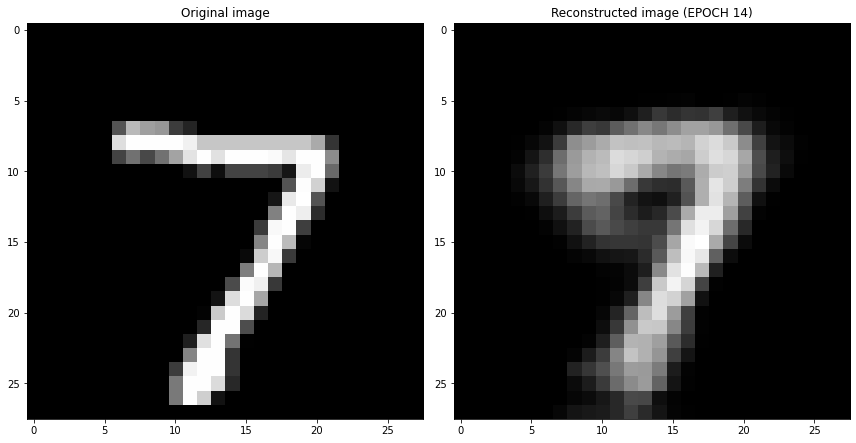

EPOCH 15/40
	 partial train loss (single batch): 0.043607
	 partial train loss (single batch): 0.040185
	 partial train loss (single batch): 0.040636
	 partial train loss (single batch): 0.042966
	 partial train loss (single batch): 0.042209
	 partial train loss (single batch): 0.042333
	 partial train loss (single batch): 0.041279
	 partial train loss (single batch): 0.042368
	 partial train loss (single batch): 0.041438
	 partial train loss (single batch): 0.042664
	 partial train loss (single batch): 0.042481
	 partial train loss (single batch): 0.041972
	 partial train loss (single batch): 0.040965
	 partial train loss (single batch): 0.043475
	 partial train loss (single batch): 0.041030
	 partial train loss (single batch): 0.041905
	 partial train loss (single batch): 0.041050
	 partial train loss (single batch): 0.040746
	 partial train loss (single batch): 0.040976
	 partial train loss (single batch): 0.042391
	 partial train loss (single batch): 0.040282
	 partial train loss (

	 partial train loss (single batch): 0.041351
	 partial train loss (single batch): 0.041277
	 partial train loss (single batch): 0.040838
	 partial train loss (single batch): 0.042098
	 partial train loss (single batch): 0.042184
	 partial train loss (single batch): 0.043128
	 partial train loss (single batch): 0.041275
	 partial train loss (single batch): 0.042185
	 partial train loss (single batch): 0.042301
	 partial train loss (single batch): 0.040046
	 partial train loss (single batch): 0.041394
	 partial train loss (single batch): 0.041200
	 partial train loss (single batch): 0.042284
	 partial train loss (single batch): 0.040648
	 partial train loss (single batch): 0.043800
	 partial train loss (single batch): 0.041066
	 partial train loss (single batch): 0.040056
	 partial train loss (single batch): 0.042496
	 partial train loss (single batch): 0.042515
	 partial train loss (single batch): 0.042044
	 partial train loss (single batch): 0.041846
	 partial train loss (single batch

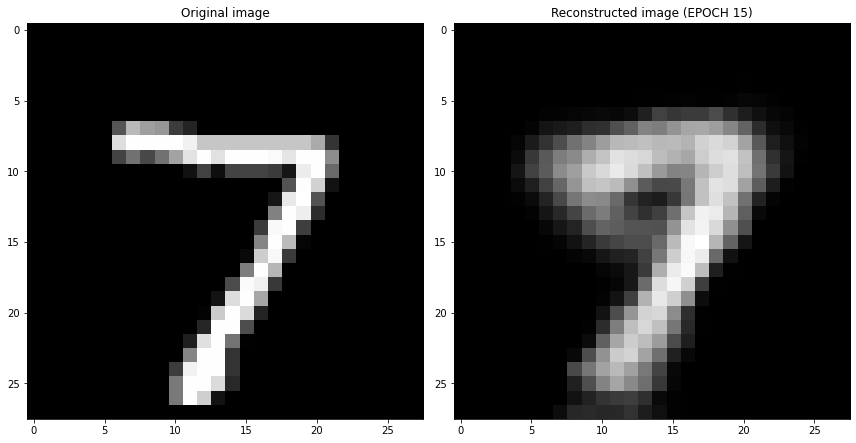

EPOCH 16/40
	 partial train loss (single batch): 0.042837
	 partial train loss (single batch): 0.042872
	 partial train loss (single batch): 0.044634
	 partial train loss (single batch): 0.041216
	 partial train loss (single batch): 0.042015
	 partial train loss (single batch): 0.040601
	 partial train loss (single batch): 0.042060
	 partial train loss (single batch): 0.042159
	 partial train loss (single batch): 0.040758
	 partial train loss (single batch): 0.040930
	 partial train loss (single batch): 0.042294
	 partial train loss (single batch): 0.040896
	 partial train loss (single batch): 0.041631
	 partial train loss (single batch): 0.042288
	 partial train loss (single batch): 0.040836
	 partial train loss (single batch): 0.039657
	 partial train loss (single batch): 0.038281
	 partial train loss (single batch): 0.042249
	 partial train loss (single batch): 0.041144
	 partial train loss (single batch): 0.042287
	 partial train loss (single batch): 0.041498
	 partial train loss (

	 partial train loss (single batch): 0.041580
	 partial train loss (single batch): 0.042649
	 partial train loss (single batch): 0.038782
	 partial train loss (single batch): 0.040531
	 partial train loss (single batch): 0.042619
	 partial train loss (single batch): 0.041440
	 partial train loss (single batch): 0.042439
	 partial train loss (single batch): 0.041306
	 partial train loss (single batch): 0.041795
	 partial train loss (single batch): 0.041034
	 partial train loss (single batch): 0.042324
	 partial train loss (single batch): 0.040234
	 partial train loss (single batch): 0.040638
	 partial train loss (single batch): 0.040511
	 partial train loss (single batch): 0.040475
	 partial train loss (single batch): 0.040450
	 partial train loss (single batch): 0.042129
	 partial train loss (single batch): 0.041794
	 partial train loss (single batch): 0.039109
	 partial train loss (single batch): 0.042405
	 partial train loss (single batch): 0.041024
	 partial train loss (single batch

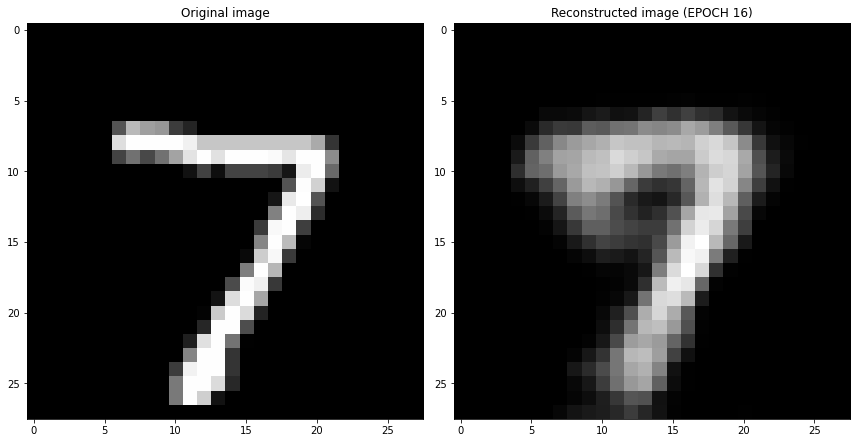

EPOCH 17/40
	 partial train loss (single batch): 0.040822
	 partial train loss (single batch): 0.043538
	 partial train loss (single batch): 0.039840
	 partial train loss (single batch): 0.042667
	 partial train loss (single batch): 0.041480
	 partial train loss (single batch): 0.042775
	 partial train loss (single batch): 0.042078
	 partial train loss (single batch): 0.040736
	 partial train loss (single batch): 0.040539
	 partial train loss (single batch): 0.040419
	 partial train loss (single batch): 0.042068
	 partial train loss (single batch): 0.042866
	 partial train loss (single batch): 0.041124
	 partial train loss (single batch): 0.041941
	 partial train loss (single batch): 0.042302
	 partial train loss (single batch): 0.039810
	 partial train loss (single batch): 0.043141
	 partial train loss (single batch): 0.040673
	 partial train loss (single batch): 0.038046
	 partial train loss (single batch): 0.040669
	 partial train loss (single batch): 0.039402
	 partial train loss (

	 partial train loss (single batch): 0.040187
	 partial train loss (single batch): 0.042269
	 partial train loss (single batch): 0.042399
	 partial train loss (single batch): 0.041000
	 partial train loss (single batch): 0.040458
	 partial train loss (single batch): 0.039983
	 partial train loss (single batch): 0.041286
	 partial train loss (single batch): 0.039408
	 partial train loss (single batch): 0.042933
	 partial train loss (single batch): 0.040153
	 partial train loss (single batch): 0.041128
	 partial train loss (single batch): 0.041932
	 partial train loss (single batch): 0.040222
	 partial train loss (single batch): 0.041513
	 partial train loss (single batch): 0.041095
	 partial train loss (single batch): 0.040868
	 partial train loss (single batch): 0.040095
	 partial train loss (single batch): 0.041894
	 partial train loss (single batch): 0.041968
	 partial train loss (single batch): 0.041721
	 partial train loss (single batch): 0.042735
	 partial train loss (single batch

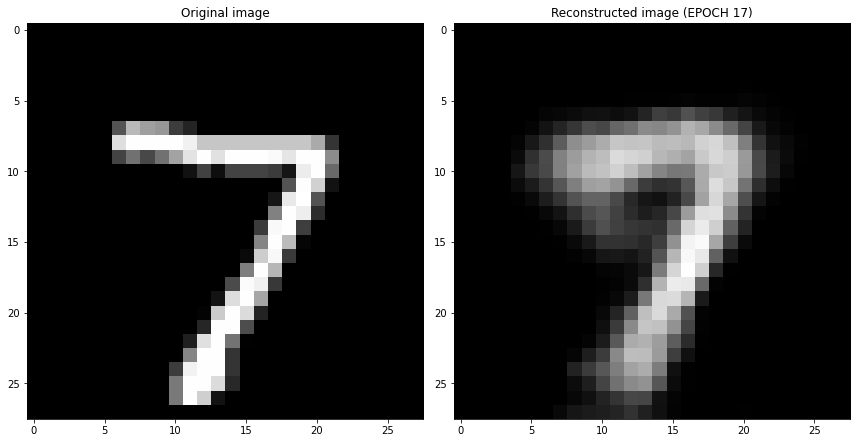

EPOCH 18/40
	 partial train loss (single batch): 0.040563
	 partial train loss (single batch): 0.039932
	 partial train loss (single batch): 0.040145
	 partial train loss (single batch): 0.041592
	 partial train loss (single batch): 0.039290
	 partial train loss (single batch): 0.040618
	 partial train loss (single batch): 0.040020
	 partial train loss (single batch): 0.041589
	 partial train loss (single batch): 0.041312
	 partial train loss (single batch): 0.040961
	 partial train loss (single batch): 0.042097
	 partial train loss (single batch): 0.040317
	 partial train loss (single batch): 0.042258
	 partial train loss (single batch): 0.042673
	 partial train loss (single batch): 0.041953
	 partial train loss (single batch): 0.040111
	 partial train loss (single batch): 0.041436
	 partial train loss (single batch): 0.041415
	 partial train loss (single batch): 0.040342
	 partial train loss (single batch): 0.039322
	 partial train loss (single batch): 0.041036
	 partial train loss (

	 partial train loss (single batch): 0.040666
	 partial train loss (single batch): 0.041036
	 partial train loss (single batch): 0.040669
	 partial train loss (single batch): 0.040142
	 partial train loss (single batch): 0.040064
	 partial train loss (single batch): 0.038533
	 partial train loss (single batch): 0.039810
	 partial train loss (single batch): 0.041116
	 partial train loss (single batch): 0.041003
	 partial train loss (single batch): 0.040761
	 partial train loss (single batch): 0.040153
	 partial train loss (single batch): 0.040747
	 partial train loss (single batch): 0.041537
	 partial train loss (single batch): 0.040935
	 partial train loss (single batch): 0.040651
	 partial train loss (single batch): 0.039787
	 partial train loss (single batch): 0.042404
	 partial train loss (single batch): 0.039897
	 partial train loss (single batch): 0.042757
	 partial train loss (single batch): 0.040248
	 partial train loss (single batch): 0.039534
	 partial train loss (single batch

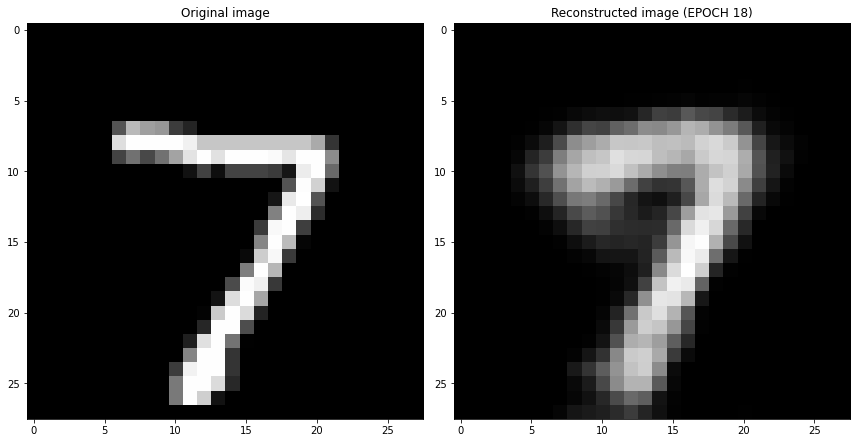

EPOCH 19/40
	 partial train loss (single batch): 0.040791
	 partial train loss (single batch): 0.040997
	 partial train loss (single batch): 0.041350
	 partial train loss (single batch): 0.040792
	 partial train loss (single batch): 0.041607
	 partial train loss (single batch): 0.040698
	 partial train loss (single batch): 0.039987
	 partial train loss (single batch): 0.040720
	 partial train loss (single batch): 0.040222
	 partial train loss (single batch): 0.042280
	 partial train loss (single batch): 0.040324
	 partial train loss (single batch): 0.041046
	 partial train loss (single batch): 0.039869
	 partial train loss (single batch): 0.041146
	 partial train loss (single batch): 0.041642
	 partial train loss (single batch): 0.040079
	 partial train loss (single batch): 0.041076
	 partial train loss (single batch): 0.038719
	 partial train loss (single batch): 0.040465
	 partial train loss (single batch): 0.043021
	 partial train loss (single batch): 0.041316
	 partial train loss (

	 partial train loss (single batch): 0.039515
	 partial train loss (single batch): 0.037507
	 partial train loss (single batch): 0.040875
	 partial train loss (single batch): 0.039066
	 partial train loss (single batch): 0.039771
	 partial train loss (single batch): 0.040826
	 partial train loss (single batch): 0.040090
	 partial train loss (single batch): 0.041233
	 partial train loss (single batch): 0.041329
	 partial train loss (single batch): 0.040545
	 partial train loss (single batch): 0.040290
	 partial train loss (single batch): 0.039882
	 partial train loss (single batch): 0.040736
	 partial train loss (single batch): 0.041230
	 partial train loss (single batch): 0.039808
	 partial train loss (single batch): 0.041768
	 partial train loss (single batch): 0.039858
	 partial train loss (single batch): 0.038533
	 partial train loss (single batch): 0.039955
	 partial train loss (single batch): 0.041834
	 partial train loss (single batch): 0.042854
	 partial train loss (single batch

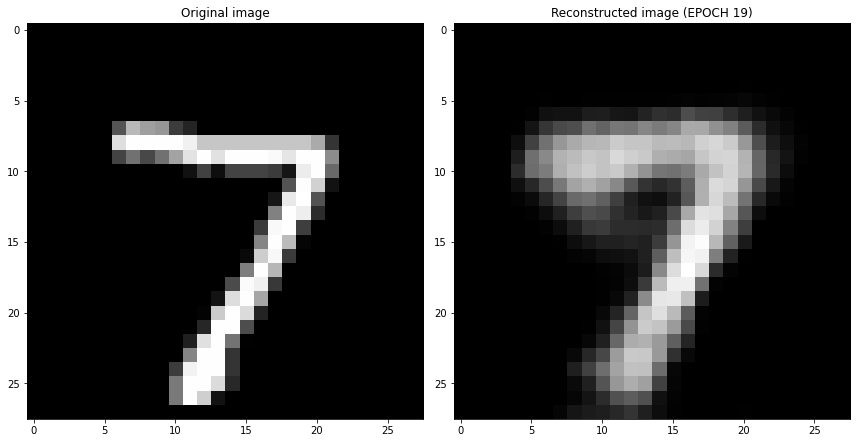

EPOCH 20/40
	 partial train loss (single batch): 0.038886
	 partial train loss (single batch): 0.039711
	 partial train loss (single batch): 0.039913
	 partial train loss (single batch): 0.040033
	 partial train loss (single batch): 0.042413
	 partial train loss (single batch): 0.041332
	 partial train loss (single batch): 0.040107
	 partial train loss (single batch): 0.041835
	 partial train loss (single batch): 0.040363
	 partial train loss (single batch): 0.042025
	 partial train loss (single batch): 0.039771
	 partial train loss (single batch): 0.039175
	 partial train loss (single batch): 0.039306
	 partial train loss (single batch): 0.041490
	 partial train loss (single batch): 0.039861
	 partial train loss (single batch): 0.041049
	 partial train loss (single batch): 0.041895
	 partial train loss (single batch): 0.041001
	 partial train loss (single batch): 0.043351
	 partial train loss (single batch): 0.039315
	 partial train loss (single batch): 0.039688
	 partial train loss (

	 partial train loss (single batch): 0.038759
	 partial train loss (single batch): 0.044271
	 partial train loss (single batch): 0.041789
	 partial train loss (single batch): 0.039305
	 partial train loss (single batch): 0.040158
	 partial train loss (single batch): 0.041010
	 partial train loss (single batch): 0.040028
	 partial train loss (single batch): 0.040784
	 partial train loss (single batch): 0.040049
	 partial train loss (single batch): 0.041430
	 partial train loss (single batch): 0.040844
	 partial train loss (single batch): 0.037139
	 partial train loss (single batch): 0.040947
	 partial train loss (single batch): 0.039751
	 partial train loss (single batch): 0.043300
	 partial train loss (single batch): 0.039587
	 partial train loss (single batch): 0.040501
	 partial train loss (single batch): 0.040088
	 partial train loss (single batch): 0.041573
	 partial train loss (single batch): 0.042756
	 partial train loss (single batch): 0.040244
	 partial train loss (single batch

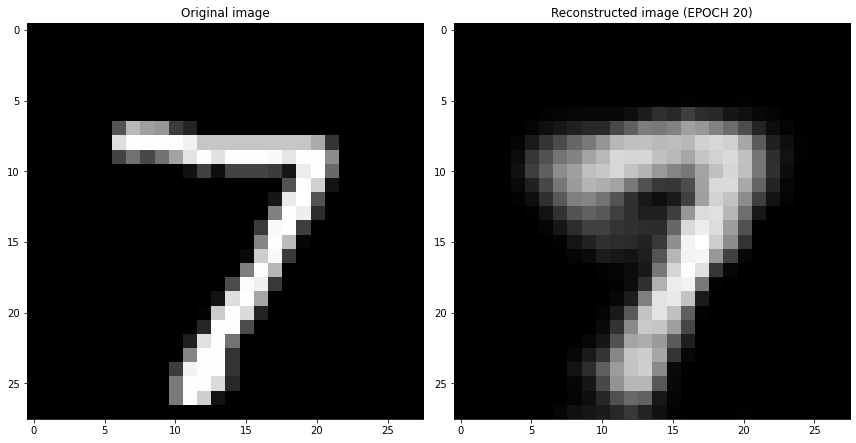

EPOCH 21/40
	 partial train loss (single batch): 0.041102
	 partial train loss (single batch): 0.040201
	 partial train loss (single batch): 0.038606
	 partial train loss (single batch): 0.038834
	 partial train loss (single batch): 0.040181
	 partial train loss (single batch): 0.040050
	 partial train loss (single batch): 0.037894
	 partial train loss (single batch): 0.037371
	 partial train loss (single batch): 0.038696
	 partial train loss (single batch): 0.040710
	 partial train loss (single batch): 0.040944
	 partial train loss (single batch): 0.038979
	 partial train loss (single batch): 0.040029
	 partial train loss (single batch): 0.041146
	 partial train loss (single batch): 0.041630
	 partial train loss (single batch): 0.039188
	 partial train loss (single batch): 0.038942
	 partial train loss (single batch): 0.041055
	 partial train loss (single batch): 0.042114
	 partial train loss (single batch): 0.039407
	 partial train loss (single batch): 0.042196
	 partial train loss (

	 partial train loss (single batch): 0.039948
	 partial train loss (single batch): 0.040652
	 partial train loss (single batch): 0.036911
	 partial train loss (single batch): 0.040608
	 partial train loss (single batch): 0.040403
	 partial train loss (single batch): 0.039064
	 partial train loss (single batch): 0.040427
	 partial train loss (single batch): 0.039121
	 partial train loss (single batch): 0.041865
	 partial train loss (single batch): 0.040433
	 partial train loss (single batch): 0.041226
	 partial train loss (single batch): 0.040302
	 partial train loss (single batch): 0.038018
	 partial train loss (single batch): 0.038500
	 partial train loss (single batch): 0.041957
	 partial train loss (single batch): 0.041102
	 partial train loss (single batch): 0.037952
	 partial train loss (single batch): 0.038247
	 partial train loss (single batch): 0.036224
	 partial train loss (single batch): 0.038410
	 partial train loss (single batch): 0.039394
	 partial train loss (single batch

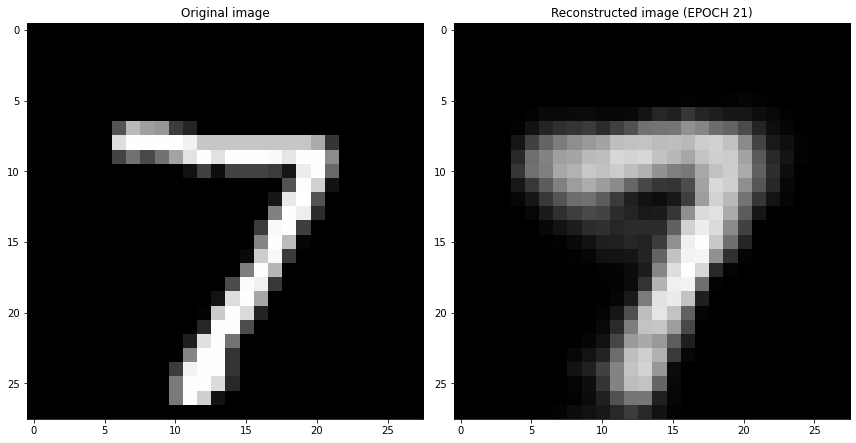

EPOCH 22/40
	 partial train loss (single batch): 0.039969
	 partial train loss (single batch): 0.039052
	 partial train loss (single batch): 0.040900
	 partial train loss (single batch): 0.040788
	 partial train loss (single batch): 0.040191
	 partial train loss (single batch): 0.039422
	 partial train loss (single batch): 0.041328
	 partial train loss (single batch): 0.040853
	 partial train loss (single batch): 0.039466
	 partial train loss (single batch): 0.041180
	 partial train loss (single batch): 0.041809
	 partial train loss (single batch): 0.041148
	 partial train loss (single batch): 0.040246
	 partial train loss (single batch): 0.039965
	 partial train loss (single batch): 0.039622
	 partial train loss (single batch): 0.039726
	 partial train loss (single batch): 0.040007
	 partial train loss (single batch): 0.039304
	 partial train loss (single batch): 0.039733
	 partial train loss (single batch): 0.038416
	 partial train loss (single batch): 0.038950
	 partial train loss (

	 partial train loss (single batch): 0.038095
	 partial train loss (single batch): 0.040506
	 partial train loss (single batch): 0.040113
	 partial train loss (single batch): 0.038569
	 partial train loss (single batch): 0.040722
	 partial train loss (single batch): 0.037166
	 partial train loss (single batch): 0.039241
	 partial train loss (single batch): 0.039187
	 partial train loss (single batch): 0.041547
	 partial train loss (single batch): 0.040656
	 partial train loss (single batch): 0.040969
	 partial train loss (single batch): 0.038324
	 partial train loss (single batch): 0.038947
	 partial train loss (single batch): 0.040873
	 partial train loss (single batch): 0.038013
	 partial train loss (single batch): 0.039455
	 partial train loss (single batch): 0.040551
	 partial train loss (single batch): 0.040115
	 partial train loss (single batch): 0.038447
	 partial train loss (single batch): 0.038041
	 partial train loss (single batch): 0.038811
	 partial train loss (single batch

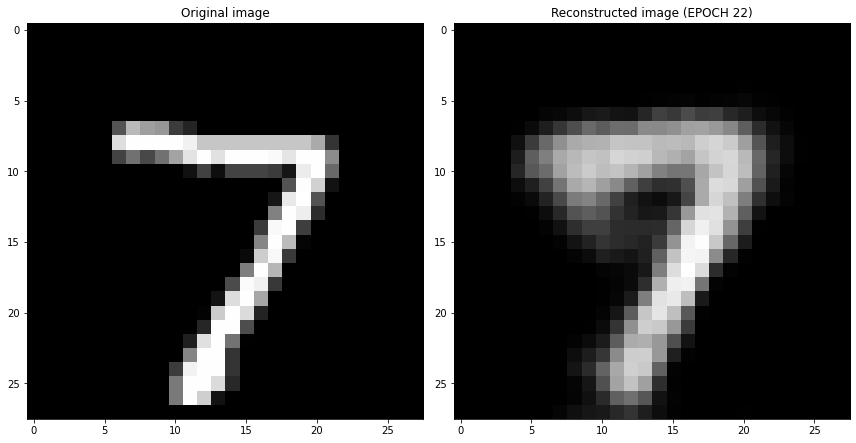

EPOCH 23/40
	 partial train loss (single batch): 0.040177
	 partial train loss (single batch): 0.038547
	 partial train loss (single batch): 0.041306
	 partial train loss (single batch): 0.040722
	 partial train loss (single batch): 0.039809
	 partial train loss (single batch): 0.039223
	 partial train loss (single batch): 0.038825
	 partial train loss (single batch): 0.039013
	 partial train loss (single batch): 0.039112
	 partial train loss (single batch): 0.039137
	 partial train loss (single batch): 0.040180
	 partial train loss (single batch): 0.038999
	 partial train loss (single batch): 0.037310
	 partial train loss (single batch): 0.040375
	 partial train loss (single batch): 0.038725
	 partial train loss (single batch): 0.038423
	 partial train loss (single batch): 0.038875
	 partial train loss (single batch): 0.037761
	 partial train loss (single batch): 0.038355
	 partial train loss (single batch): 0.038752
	 partial train loss (single batch): 0.038562
	 partial train loss (

	 partial train loss (single batch): 0.040860
	 partial train loss (single batch): 0.039139
	 partial train loss (single batch): 0.039853
	 partial train loss (single batch): 0.040544
	 partial train loss (single batch): 0.040122
	 partial train loss (single batch): 0.040969
	 partial train loss (single batch): 0.040783
	 partial train loss (single batch): 0.039522
	 partial train loss (single batch): 0.039632
	 partial train loss (single batch): 0.040527
	 partial train loss (single batch): 0.039751
	 partial train loss (single batch): 0.040520
	 partial train loss (single batch): 0.039542
	 partial train loss (single batch): 0.037670
	 partial train loss (single batch): 0.040062
	 partial train loss (single batch): 0.041457
	 partial train loss (single batch): 0.040316
	 partial train loss (single batch): 0.040276
	 partial train loss (single batch): 0.040056
	 partial train loss (single batch): 0.040651
	 partial train loss (single batch): 0.040702
	 partial train loss (single batch

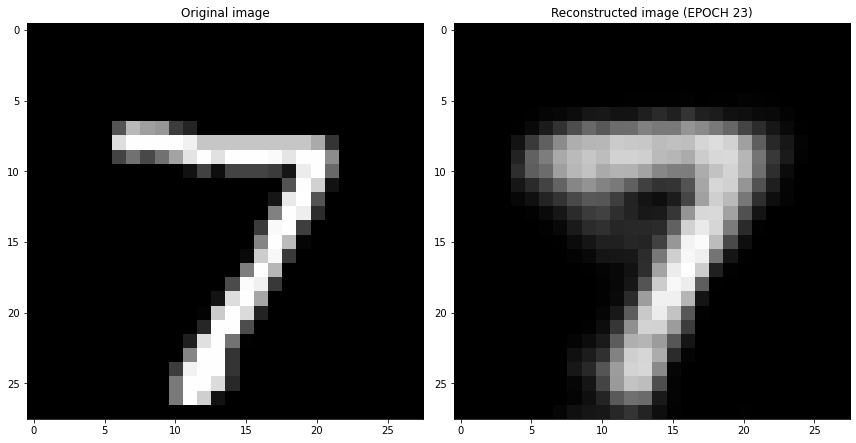

EPOCH 24/40
	 partial train loss (single batch): 0.037982
	 partial train loss (single batch): 0.038592
	 partial train loss (single batch): 0.040724
	 partial train loss (single batch): 0.038217
	 partial train loss (single batch): 0.039012
	 partial train loss (single batch): 0.040665
	 partial train loss (single batch): 0.037692
	 partial train loss (single batch): 0.040109
	 partial train loss (single batch): 0.039828
	 partial train loss (single batch): 0.038875
	 partial train loss (single batch): 0.040267
	 partial train loss (single batch): 0.039196
	 partial train loss (single batch): 0.040919
	 partial train loss (single batch): 0.039286
	 partial train loss (single batch): 0.039555
	 partial train loss (single batch): 0.038173
	 partial train loss (single batch): 0.040424
	 partial train loss (single batch): 0.038302
	 partial train loss (single batch): 0.037688
	 partial train loss (single batch): 0.041130
	 partial train loss (single batch): 0.039690
	 partial train loss (

	 partial train loss (single batch): 0.039624
	 partial train loss (single batch): 0.041380
	 partial train loss (single batch): 0.039344
	 partial train loss (single batch): 0.040699
	 partial train loss (single batch): 0.039654
	 partial train loss (single batch): 0.040635
	 partial train loss (single batch): 0.039745
	 partial train loss (single batch): 0.037561
	 partial train loss (single batch): 0.041028
	 partial train loss (single batch): 0.038403
	 partial train loss (single batch): 0.038403
	 partial train loss (single batch): 0.038564
	 partial train loss (single batch): 0.039420
	 partial train loss (single batch): 0.038976
	 partial train loss (single batch): 0.040957
	 partial train loss (single batch): 0.039200
	 partial train loss (single batch): 0.039919
	 partial train loss (single batch): 0.040890
	 partial train loss (single batch): 0.038713
	 partial train loss (single batch): 0.037805
	 partial train loss (single batch): 0.036337
	 partial train loss (single batch

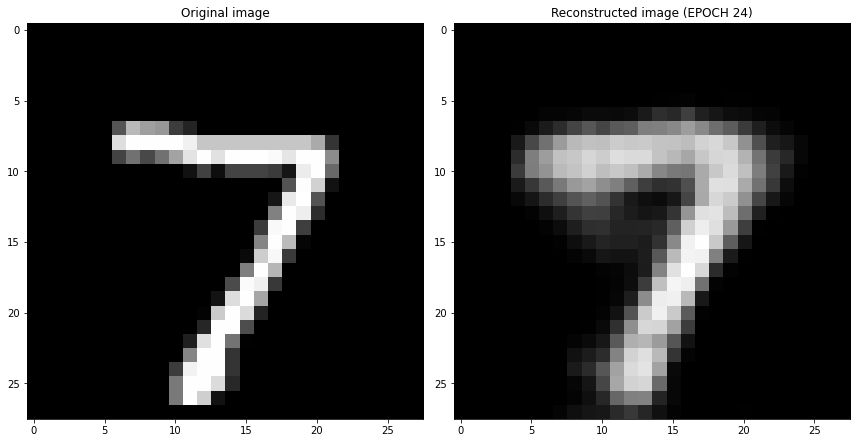

EPOCH 25/40
	 partial train loss (single batch): 0.038825
	 partial train loss (single batch): 0.040284
	 partial train loss (single batch): 0.041539
	 partial train loss (single batch): 0.039427
	 partial train loss (single batch): 0.039503
	 partial train loss (single batch): 0.039838
	 partial train loss (single batch): 0.038779
	 partial train loss (single batch): 0.039876
	 partial train loss (single batch): 0.042323
	 partial train loss (single batch): 0.038143
	 partial train loss (single batch): 0.040655
	 partial train loss (single batch): 0.038841
	 partial train loss (single batch): 0.038099
	 partial train loss (single batch): 0.038613
	 partial train loss (single batch): 0.039775
	 partial train loss (single batch): 0.038849
	 partial train loss (single batch): 0.038311
	 partial train loss (single batch): 0.039296
	 partial train loss (single batch): 0.040080
	 partial train loss (single batch): 0.039964
	 partial train loss (single batch): 0.038188
	 partial train loss (

	 partial train loss (single batch): 0.039544
	 partial train loss (single batch): 0.038835
	 partial train loss (single batch): 0.038806
	 partial train loss (single batch): 0.039726
	 partial train loss (single batch): 0.040259
	 partial train loss (single batch): 0.037888
	 partial train loss (single batch): 0.038790
	 partial train loss (single batch): 0.036616
	 partial train loss (single batch): 0.039868
	 partial train loss (single batch): 0.037825
	 partial train loss (single batch): 0.040892
	 partial train loss (single batch): 0.037991
	 partial train loss (single batch): 0.041232
	 partial train loss (single batch): 0.040096
	 partial train loss (single batch): 0.041306
	 partial train loss (single batch): 0.038842
	 partial train loss (single batch): 0.039419
	 partial train loss (single batch): 0.039169
	 partial train loss (single batch): 0.038639
	 partial train loss (single batch): 0.039489
	 partial train loss (single batch): 0.040284
	 partial train loss (single batch

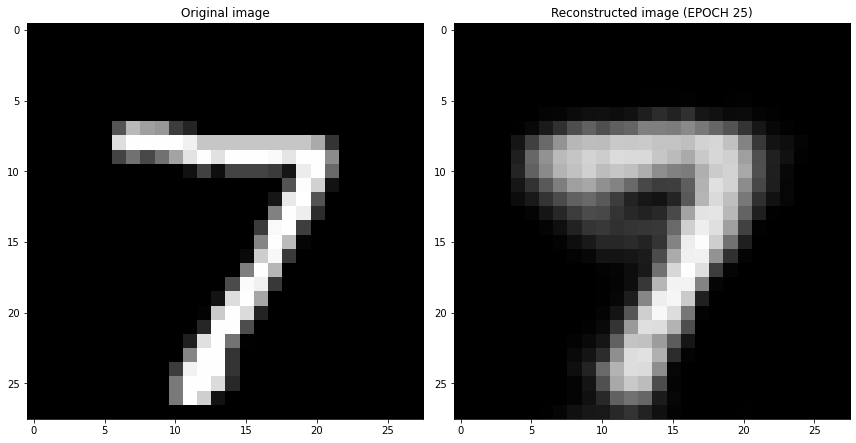

EPOCH 26/40
	 partial train loss (single batch): 0.037419
	 partial train loss (single batch): 0.039050
	 partial train loss (single batch): 0.038044
	 partial train loss (single batch): 0.038442
	 partial train loss (single batch): 0.039744
	 partial train loss (single batch): 0.037731
	 partial train loss (single batch): 0.036978
	 partial train loss (single batch): 0.038890
	 partial train loss (single batch): 0.039687
	 partial train loss (single batch): 0.038217
	 partial train loss (single batch): 0.039777
	 partial train loss (single batch): 0.038700
	 partial train loss (single batch): 0.040189
	 partial train loss (single batch): 0.039136
	 partial train loss (single batch): 0.039758
	 partial train loss (single batch): 0.036714
	 partial train loss (single batch): 0.038795
	 partial train loss (single batch): 0.038453
	 partial train loss (single batch): 0.039634
	 partial train loss (single batch): 0.039431
	 partial train loss (single batch): 0.039119
	 partial train loss (

	 partial train loss (single batch): 0.038698
	 partial train loss (single batch): 0.038142
	 partial train loss (single batch): 0.039593
	 partial train loss (single batch): 0.040155
	 partial train loss (single batch): 0.041617
	 partial train loss (single batch): 0.037697
	 partial train loss (single batch): 0.037274
	 partial train loss (single batch): 0.039461
	 partial train loss (single batch): 0.038701
	 partial train loss (single batch): 0.038653
	 partial train loss (single batch): 0.038086
	 partial train loss (single batch): 0.039369
	 partial train loss (single batch): 0.036859
	 partial train loss (single batch): 0.038839
	 partial train loss (single batch): 0.038139
	 partial train loss (single batch): 0.040172
	 partial train loss (single batch): 0.040151
	 partial train loss (single batch): 0.039251
	 partial train loss (single batch): 0.039400
	 partial train loss (single batch): 0.038706
	 partial train loss (single batch): 0.038445
	 partial train loss (single batch

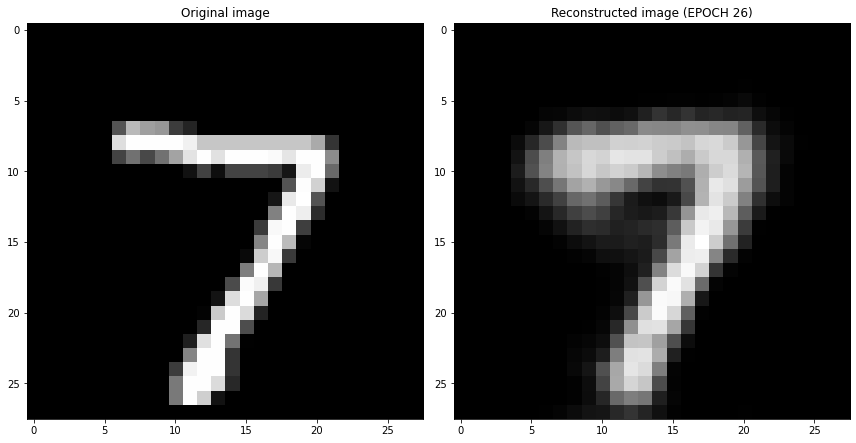

EPOCH 27/40
	 partial train loss (single batch): 0.040045
	 partial train loss (single batch): 0.038483
	 partial train loss (single batch): 0.037352
	 partial train loss (single batch): 0.035994
	 partial train loss (single batch): 0.040060
	 partial train loss (single batch): 0.040717
	 partial train loss (single batch): 0.039249
	 partial train loss (single batch): 0.037226
	 partial train loss (single batch): 0.039461
	 partial train loss (single batch): 0.038571
	 partial train loss (single batch): 0.040177
	 partial train loss (single batch): 0.039124
	 partial train loss (single batch): 0.038206
	 partial train loss (single batch): 0.037831
	 partial train loss (single batch): 0.038241
	 partial train loss (single batch): 0.040086
	 partial train loss (single batch): 0.037540
	 partial train loss (single batch): 0.038585
	 partial train loss (single batch): 0.037754
	 partial train loss (single batch): 0.038213
	 partial train loss (single batch): 0.037827
	 partial train loss (

	 partial train loss (single batch): 0.040769
	 partial train loss (single batch): 0.039738
	 partial train loss (single batch): 0.038736
	 partial train loss (single batch): 0.037706
	 partial train loss (single batch): 0.039228
	 partial train loss (single batch): 0.040245
	 partial train loss (single batch): 0.039822
	 partial train loss (single batch): 0.041696
	 partial train loss (single batch): 0.039823
	 partial train loss (single batch): 0.038407
	 partial train loss (single batch): 0.039641
	 partial train loss (single batch): 0.038957
	 partial train loss (single batch): 0.037312
	 partial train loss (single batch): 0.038768
	 partial train loss (single batch): 0.038956
	 partial train loss (single batch): 0.038720
	 partial train loss (single batch): 0.038707
	 partial train loss (single batch): 0.039444
	 partial train loss (single batch): 0.038815
	 partial train loss (single batch): 0.040274
	 partial train loss (single batch): 0.041424
	 partial train loss (single batch

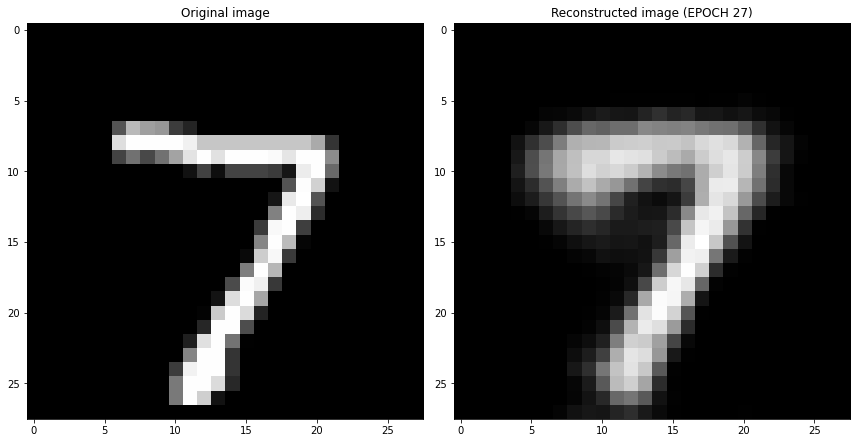

EPOCH 28/40
	 partial train loss (single batch): 0.038940
	 partial train loss (single batch): 0.037916
	 partial train loss (single batch): 0.040624
	 partial train loss (single batch): 0.040452
	 partial train loss (single batch): 0.037462
	 partial train loss (single batch): 0.040270
	 partial train loss (single batch): 0.039170
	 partial train loss (single batch): 0.038318
	 partial train loss (single batch): 0.037409
	 partial train loss (single batch): 0.037561
	 partial train loss (single batch): 0.038869
	 partial train loss (single batch): 0.038457
	 partial train loss (single batch): 0.039608
	 partial train loss (single batch): 0.038798
	 partial train loss (single batch): 0.039235
	 partial train loss (single batch): 0.038744
	 partial train loss (single batch): 0.039584
	 partial train loss (single batch): 0.037999
	 partial train loss (single batch): 0.038072
	 partial train loss (single batch): 0.039769
	 partial train loss (single batch): 0.040218
	 partial train loss (

	 partial train loss (single batch): 0.040067
	 partial train loss (single batch): 0.039931
	 partial train loss (single batch): 0.038216
	 partial train loss (single batch): 0.040573
	 partial train loss (single batch): 0.039025
	 partial train loss (single batch): 0.037987
	 partial train loss (single batch): 0.037656
	 partial train loss (single batch): 0.039260
	 partial train loss (single batch): 0.039187
	 partial train loss (single batch): 0.038987
	 partial train loss (single batch): 0.037537
	 partial train loss (single batch): 0.040763
	 partial train loss (single batch): 0.038907
	 partial train loss (single batch): 0.037919
	 partial train loss (single batch): 0.038360
	 partial train loss (single batch): 0.040106
	 partial train loss (single batch): 0.039077
	 partial train loss (single batch): 0.037817
	 partial train loss (single batch): 0.040770
	 partial train loss (single batch): 0.040676
	 partial train loss (single batch): 0.036909
	 partial train loss (single batch

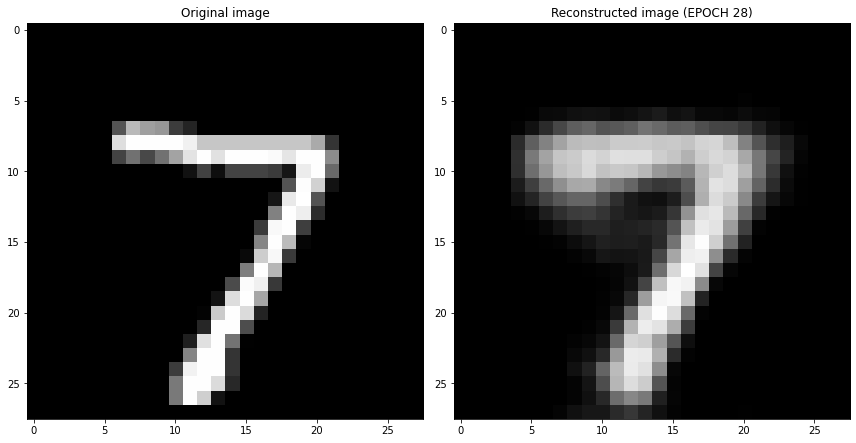

EPOCH 29/40
	 partial train loss (single batch): 0.037723
	 partial train loss (single batch): 0.039881
	 partial train loss (single batch): 0.038333
	 partial train loss (single batch): 0.037762
	 partial train loss (single batch): 0.039536
	 partial train loss (single batch): 0.038262
	 partial train loss (single batch): 0.037328
	 partial train loss (single batch): 0.039730
	 partial train loss (single batch): 0.038153
	 partial train loss (single batch): 0.036689
	 partial train loss (single batch): 0.037944
	 partial train loss (single batch): 0.038604
	 partial train loss (single batch): 0.038554
	 partial train loss (single batch): 0.039594
	 partial train loss (single batch): 0.038143
	 partial train loss (single batch): 0.038147
	 partial train loss (single batch): 0.037648
	 partial train loss (single batch): 0.039243
	 partial train loss (single batch): 0.039203
	 partial train loss (single batch): 0.037673
	 partial train loss (single batch): 0.039183
	 partial train loss (

	 partial train loss (single batch): 0.036109
	 partial train loss (single batch): 0.039605
	 partial train loss (single batch): 0.037759
	 partial train loss (single batch): 0.038561
	 partial train loss (single batch): 0.037876
	 partial train loss (single batch): 0.038762
	 partial train loss (single batch): 0.039085
	 partial train loss (single batch): 0.040161
	 partial train loss (single batch): 0.038043
	 partial train loss (single batch): 0.040185
	 partial train loss (single batch): 0.039902
	 partial train loss (single batch): 0.040546
	 partial train loss (single batch): 0.039075
	 partial train loss (single batch): 0.040322
	 partial train loss (single batch): 0.039700
	 partial train loss (single batch): 0.038689
	 partial train loss (single batch): 0.040456
	 partial train loss (single batch): 0.037719
	 partial train loss (single batch): 0.039870
	 partial train loss (single batch): 0.038726
	 partial train loss (single batch): 0.039922
	 partial train loss (single batch

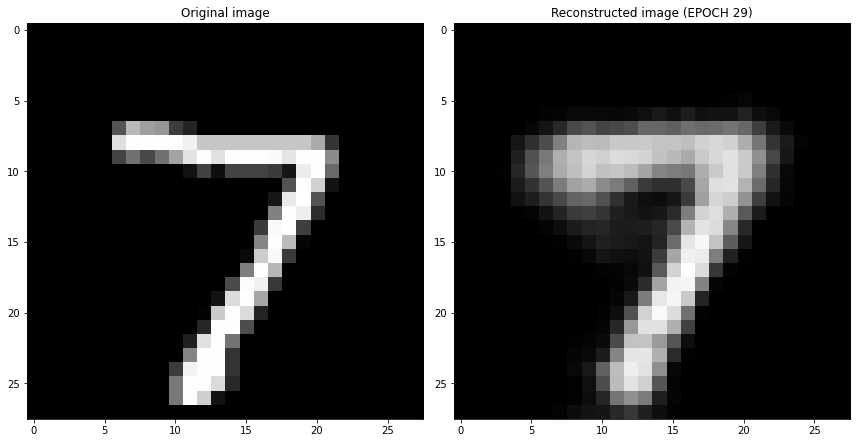

EPOCH 30/40
	 partial train loss (single batch): 0.036975
	 partial train loss (single batch): 0.037817
	 partial train loss (single batch): 0.039034
	 partial train loss (single batch): 0.038738
	 partial train loss (single batch): 0.038917
	 partial train loss (single batch): 0.038039
	 partial train loss (single batch): 0.039031
	 partial train loss (single batch): 0.037428
	 partial train loss (single batch): 0.041176
	 partial train loss (single batch): 0.040175
	 partial train loss (single batch): 0.037401
	 partial train loss (single batch): 0.039307
	 partial train loss (single batch): 0.039492
	 partial train loss (single batch): 0.037614
	 partial train loss (single batch): 0.038788
	 partial train loss (single batch): 0.039083
	 partial train loss (single batch): 0.038490
	 partial train loss (single batch): 0.039709
	 partial train loss (single batch): 0.038429
	 partial train loss (single batch): 0.038825
	 partial train loss (single batch): 0.037655
	 partial train loss (

	 partial train loss (single batch): 0.037293
	 partial train loss (single batch): 0.040978
	 partial train loss (single batch): 0.036086
	 partial train loss (single batch): 0.039755
	 partial train loss (single batch): 0.038825
	 partial train loss (single batch): 0.037619
	 partial train loss (single batch): 0.037237
	 partial train loss (single batch): 0.037873
	 partial train loss (single batch): 0.037607
	 partial train loss (single batch): 0.038916
	 partial train loss (single batch): 0.040421
	 partial train loss (single batch): 0.039594
	 partial train loss (single batch): 0.039726
	 partial train loss (single batch): 0.038503
	 partial train loss (single batch): 0.038878
	 partial train loss (single batch): 0.038653
	 partial train loss (single batch): 0.039122
	 partial train loss (single batch): 0.039391
	 partial train loss (single batch): 0.038826
	 partial train loss (single batch): 0.040144
	 partial train loss (single batch): 0.039228
	 partial train loss (single batch

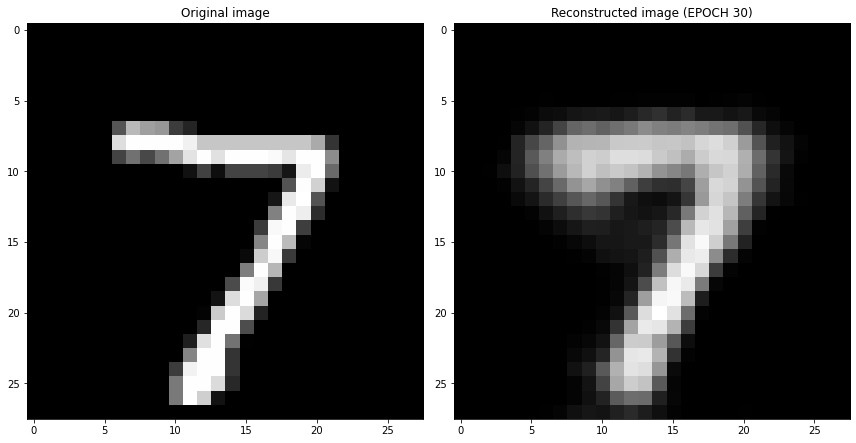

EPOCH 31/40
	 partial train loss (single batch): 0.037562
	 partial train loss (single batch): 0.039828
	 partial train loss (single batch): 0.040075
	 partial train loss (single batch): 0.039161
	 partial train loss (single batch): 0.038251
	 partial train loss (single batch): 0.038604
	 partial train loss (single batch): 0.038617
	 partial train loss (single batch): 0.036660
	 partial train loss (single batch): 0.039012
	 partial train loss (single batch): 0.037977
	 partial train loss (single batch): 0.037371
	 partial train loss (single batch): 0.038609
	 partial train loss (single batch): 0.039452
	 partial train loss (single batch): 0.037162
	 partial train loss (single batch): 0.040861
	 partial train loss (single batch): 0.038450
	 partial train loss (single batch): 0.040670
	 partial train loss (single batch): 0.039030
	 partial train loss (single batch): 0.037936
	 partial train loss (single batch): 0.039981
	 partial train loss (single batch): 0.038212
	 partial train loss (

	 partial train loss (single batch): 0.036818
	 partial train loss (single batch): 0.038245
	 partial train loss (single batch): 0.039010
	 partial train loss (single batch): 0.039901
	 partial train loss (single batch): 0.039539
	 partial train loss (single batch): 0.039200
	 partial train loss (single batch): 0.037394
	 partial train loss (single batch): 0.038634
	 partial train loss (single batch): 0.038273
	 partial train loss (single batch): 0.036790
	 partial train loss (single batch): 0.039372
	 partial train loss (single batch): 0.037453
	 partial train loss (single batch): 0.038965
	 partial train loss (single batch): 0.038480
	 partial train loss (single batch): 0.038183
	 partial train loss (single batch): 0.038725
	 partial train loss (single batch): 0.040941
	 partial train loss (single batch): 0.037109
	 partial train loss (single batch): 0.038601
	 partial train loss (single batch): 0.040384
	 partial train loss (single batch): 0.037374
	 partial train loss (single batch

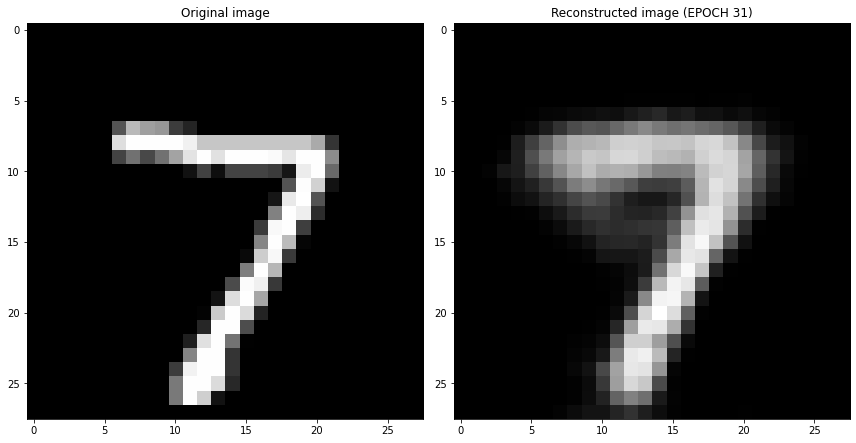

EPOCH 32/40
	 partial train loss (single batch): 0.036306
	 partial train loss (single batch): 0.038801
	 partial train loss (single batch): 0.038072
	 partial train loss (single batch): 0.038014
	 partial train loss (single batch): 0.038977
	 partial train loss (single batch): 0.037981
	 partial train loss (single batch): 0.037346
	 partial train loss (single batch): 0.037850
	 partial train loss (single batch): 0.038153
	 partial train loss (single batch): 0.037357
	 partial train loss (single batch): 0.039778
	 partial train loss (single batch): 0.037567
	 partial train loss (single batch): 0.040024
	 partial train loss (single batch): 0.036543
	 partial train loss (single batch): 0.039418
	 partial train loss (single batch): 0.037786
	 partial train loss (single batch): 0.038789
	 partial train loss (single batch): 0.037270
	 partial train loss (single batch): 0.038748
	 partial train loss (single batch): 0.038042
	 partial train loss (single batch): 0.039453
	 partial train loss (

	 partial train loss (single batch): 0.039761
	 partial train loss (single batch): 0.039403
	 partial train loss (single batch): 0.037590
	 partial train loss (single batch): 0.036474
	 partial train loss (single batch): 0.039065
	 partial train loss (single batch): 0.039859
	 partial train loss (single batch): 0.038999
	 partial train loss (single batch): 0.038985
	 partial train loss (single batch): 0.038173
	 partial train loss (single batch): 0.038250
	 partial train loss (single batch): 0.036572
	 partial train loss (single batch): 0.039583
	 partial train loss (single batch): 0.037127
	 partial train loss (single batch): 0.038034
	 partial train loss (single batch): 0.039688
	 partial train loss (single batch): 0.038038
	 partial train loss (single batch): 0.038086
	 partial train loss (single batch): 0.039761
	 partial train loss (single batch): 0.039077
	 partial train loss (single batch): 0.036854
	 partial train loss (single batch): 0.039145
	 partial train loss (single batch

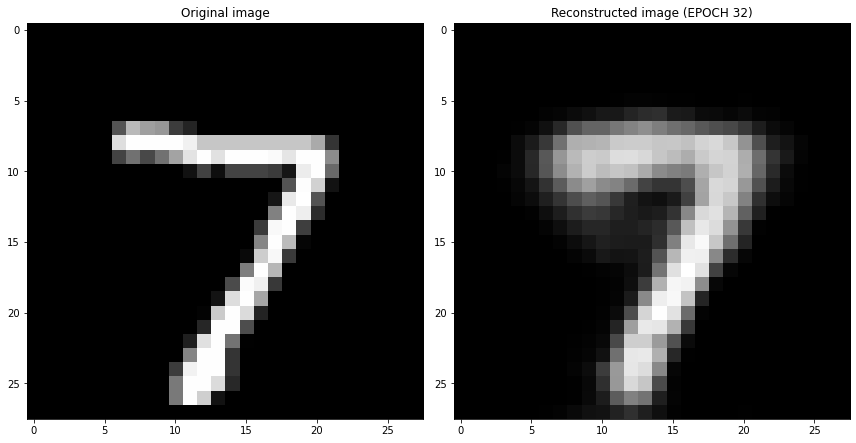

EPOCH 33/40
	 partial train loss (single batch): 0.038918
	 partial train loss (single batch): 0.038914
	 partial train loss (single batch): 0.037563
	 partial train loss (single batch): 0.037682
	 partial train loss (single batch): 0.038746
	 partial train loss (single batch): 0.040860
	 partial train loss (single batch): 0.039186
	 partial train loss (single batch): 0.038460
	 partial train loss (single batch): 0.036021
	 partial train loss (single batch): 0.037000
	 partial train loss (single batch): 0.038405
	 partial train loss (single batch): 0.037824
	 partial train loss (single batch): 0.039817
	 partial train loss (single batch): 0.039474
	 partial train loss (single batch): 0.039867
	 partial train loss (single batch): 0.037365
	 partial train loss (single batch): 0.038099
	 partial train loss (single batch): 0.038551
	 partial train loss (single batch): 0.039101
	 partial train loss (single batch): 0.036063
	 partial train loss (single batch): 0.038506
	 partial train loss (

	 partial train loss (single batch): 0.038034
	 partial train loss (single batch): 0.038784
	 partial train loss (single batch): 0.038507
	 partial train loss (single batch): 0.038131
	 partial train loss (single batch): 0.036539
	 partial train loss (single batch): 0.039401
	 partial train loss (single batch): 0.038515
	 partial train loss (single batch): 0.039822
	 partial train loss (single batch): 0.037713
	 partial train loss (single batch): 0.038257
	 partial train loss (single batch): 0.039348
	 partial train loss (single batch): 0.038606
	 partial train loss (single batch): 0.038090
	 partial train loss (single batch): 0.038359
	 partial train loss (single batch): 0.038089
	 partial train loss (single batch): 0.038103
	 partial train loss (single batch): 0.040408
	 partial train loss (single batch): 0.038204
	 partial train loss (single batch): 0.039890
	 partial train loss (single batch): 0.037856
	 partial train loss (single batch): 0.038417
	 partial train loss (single batch

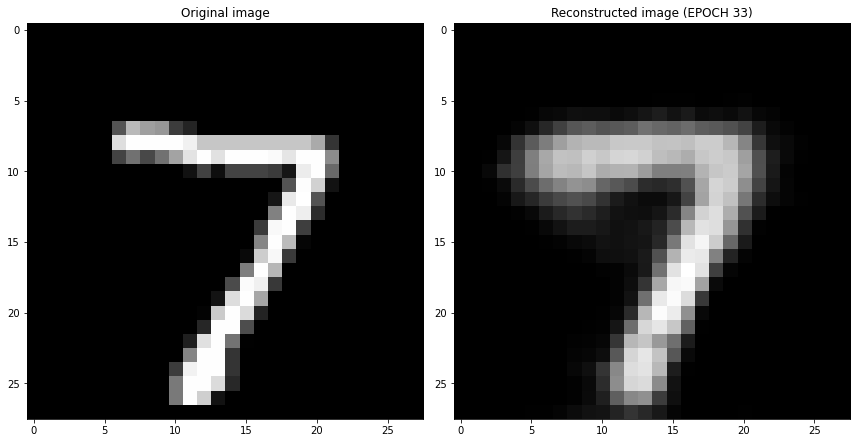

EPOCH 34/40
	 partial train loss (single batch): 0.038006
	 partial train loss (single batch): 0.038559
	 partial train loss (single batch): 0.038386
	 partial train loss (single batch): 0.039083
	 partial train loss (single batch): 0.037141
	 partial train loss (single batch): 0.039079
	 partial train loss (single batch): 0.037605
	 partial train loss (single batch): 0.037742
	 partial train loss (single batch): 0.038553
	 partial train loss (single batch): 0.040278
	 partial train loss (single batch): 0.038320
	 partial train loss (single batch): 0.040219
	 partial train loss (single batch): 0.039033
	 partial train loss (single batch): 0.037867
	 partial train loss (single batch): 0.037784
	 partial train loss (single batch): 0.036802
	 partial train loss (single batch): 0.037343
	 partial train loss (single batch): 0.037360
	 partial train loss (single batch): 0.039131
	 partial train loss (single batch): 0.038634
	 partial train loss (single batch): 0.040369
	 partial train loss (

	 partial train loss (single batch): 0.038846
	 partial train loss (single batch): 0.038258
	 partial train loss (single batch): 0.037921
	 partial train loss (single batch): 0.038717
	 partial train loss (single batch): 0.038602
	 partial train loss (single batch): 0.039401
	 partial train loss (single batch): 0.037363
	 partial train loss (single batch): 0.038543
	 partial train loss (single batch): 0.035979
	 partial train loss (single batch): 0.037429
	 partial train loss (single batch): 0.038142
	 partial train loss (single batch): 0.038644
	 partial train loss (single batch): 0.037114
	 partial train loss (single batch): 0.038609
	 partial train loss (single batch): 0.037981
	 partial train loss (single batch): 0.039139
	 partial train loss (single batch): 0.039565
	 partial train loss (single batch): 0.039196
	 partial train loss (single batch): 0.036195
	 partial train loss (single batch): 0.040238
	 partial train loss (single batch): 0.037123
	 partial train loss (single batch

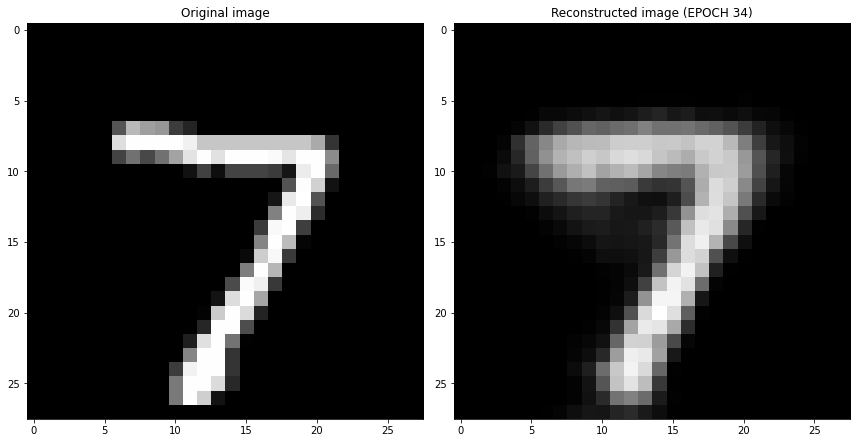

EPOCH 35/40
	 partial train loss (single batch): 0.037849
	 partial train loss (single batch): 0.038383
	 partial train loss (single batch): 0.039717
	 partial train loss (single batch): 0.038117
	 partial train loss (single batch): 0.037104
	 partial train loss (single batch): 0.038573
	 partial train loss (single batch): 0.038312
	 partial train loss (single batch): 0.039224
	 partial train loss (single batch): 0.039497
	 partial train loss (single batch): 0.038638
	 partial train loss (single batch): 0.037757
	 partial train loss (single batch): 0.038999
	 partial train loss (single batch): 0.037846
	 partial train loss (single batch): 0.038140
	 partial train loss (single batch): 0.038521
	 partial train loss (single batch): 0.038465
	 partial train loss (single batch): 0.037023
	 partial train loss (single batch): 0.037987
	 partial train loss (single batch): 0.038694
	 partial train loss (single batch): 0.037525
	 partial train loss (single batch): 0.038691
	 partial train loss (

	 partial train loss (single batch): 0.035314
	 partial train loss (single batch): 0.038435
	 partial train loss (single batch): 0.036023
	 partial train loss (single batch): 0.037050
	 partial train loss (single batch): 0.038701
	 partial train loss (single batch): 0.037843
	 partial train loss (single batch): 0.038054
	 partial train loss (single batch): 0.037316
	 partial train loss (single batch): 0.036349
	 partial train loss (single batch): 0.036847
	 partial train loss (single batch): 0.038098
	 partial train loss (single batch): 0.036934
	 partial train loss (single batch): 0.037808
	 partial train loss (single batch): 0.039429
	 partial train loss (single batch): 0.037706
	 partial train loss (single batch): 0.039632
	 partial train loss (single batch): 0.038677
	 partial train loss (single batch): 0.040216
	 partial train loss (single batch): 0.037710
	 partial train loss (single batch): 0.038862
	 partial train loss (single batch): 0.039593
	 partial train loss (single batch

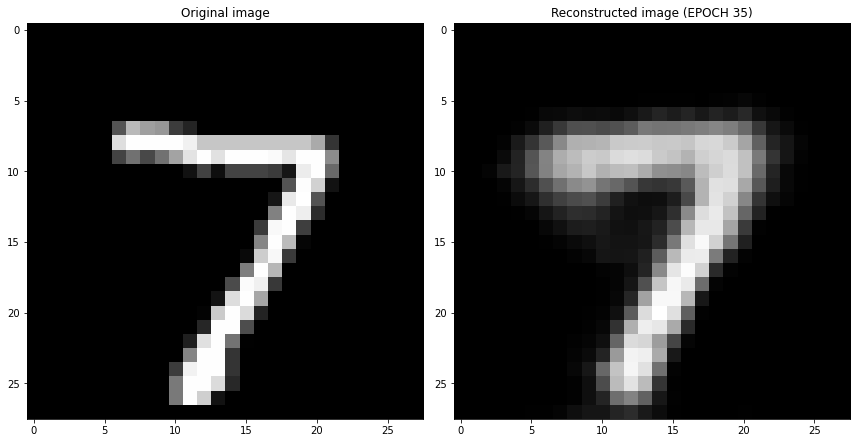

EPOCH 36/40
	 partial train loss (single batch): 0.039719
	 partial train loss (single batch): 0.038615
	 partial train loss (single batch): 0.038933
	 partial train loss (single batch): 0.039673
	 partial train loss (single batch): 0.036661
	 partial train loss (single batch): 0.037364
	 partial train loss (single batch): 0.037689
	 partial train loss (single batch): 0.037548
	 partial train loss (single batch): 0.038390
	 partial train loss (single batch): 0.037053
	 partial train loss (single batch): 0.037091
	 partial train loss (single batch): 0.038742
	 partial train loss (single batch): 0.038618
	 partial train loss (single batch): 0.037271
	 partial train loss (single batch): 0.039353
	 partial train loss (single batch): 0.038368
	 partial train loss (single batch): 0.037319
	 partial train loss (single batch): 0.038613
	 partial train loss (single batch): 0.037893
	 partial train loss (single batch): 0.037034
	 partial train loss (single batch): 0.037616
	 partial train loss (

	 partial train loss (single batch): 0.037906
	 partial train loss (single batch): 0.038227
	 partial train loss (single batch): 0.038327
	 partial train loss (single batch): 0.037958
	 partial train loss (single batch): 0.038081
	 partial train loss (single batch): 0.037912
	 partial train loss (single batch): 0.038063
	 partial train loss (single batch): 0.037906
	 partial train loss (single batch): 0.039458
	 partial train loss (single batch): 0.035770
	 partial train loss (single batch): 0.037177
	 partial train loss (single batch): 0.038251
	 partial train loss (single batch): 0.038150
	 partial train loss (single batch): 0.037743
	 partial train loss (single batch): 0.037361
	 partial train loss (single batch): 0.040486
	 partial train loss (single batch): 0.037884
	 partial train loss (single batch): 0.038889
	 partial train loss (single batch): 0.037402
	 partial train loss (single batch): 0.039385
	 partial train loss (single batch): 0.039527
	 partial train loss (single batch

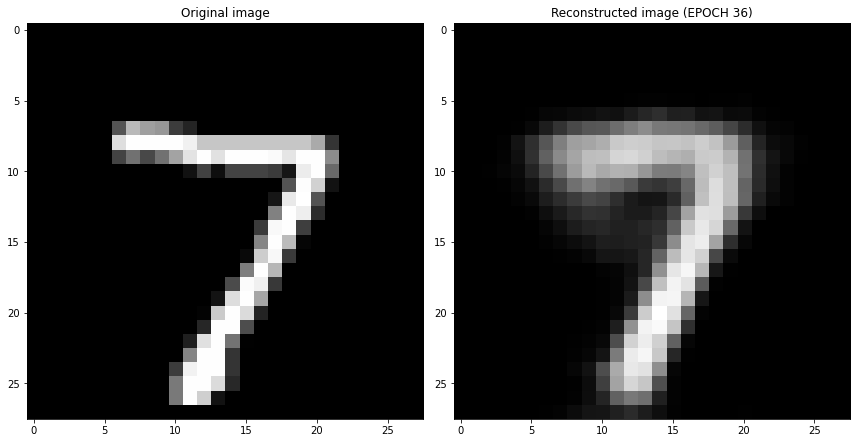

EPOCH 37/40
	 partial train loss (single batch): 0.037435
	 partial train loss (single batch): 0.037266
	 partial train loss (single batch): 0.037097
	 partial train loss (single batch): 0.036687
	 partial train loss (single batch): 0.037301
	 partial train loss (single batch): 0.037629
	 partial train loss (single batch): 0.036959
	 partial train loss (single batch): 0.038665
	 partial train loss (single batch): 0.038957
	 partial train loss (single batch): 0.038342
	 partial train loss (single batch): 0.038340
	 partial train loss (single batch): 0.038541
	 partial train loss (single batch): 0.037108
	 partial train loss (single batch): 0.037532
	 partial train loss (single batch): 0.038088
	 partial train loss (single batch): 0.036893
	 partial train loss (single batch): 0.036903
	 partial train loss (single batch): 0.037673
	 partial train loss (single batch): 0.036691
	 partial train loss (single batch): 0.040284
	 partial train loss (single batch): 0.037715
	 partial train loss (

	 partial train loss (single batch): 0.039215
	 partial train loss (single batch): 0.038717
	 partial train loss (single batch): 0.038109
	 partial train loss (single batch): 0.039005
	 partial train loss (single batch): 0.036330
	 partial train loss (single batch): 0.039749
	 partial train loss (single batch): 0.035996
	 partial train loss (single batch): 0.037238
	 partial train loss (single batch): 0.038925
	 partial train loss (single batch): 0.037234
	 partial train loss (single batch): 0.035710
	 partial train loss (single batch): 0.039650
	 partial train loss (single batch): 0.036672
	 partial train loss (single batch): 0.037732
	 partial train loss (single batch): 0.037734
	 partial train loss (single batch): 0.037351
	 partial train loss (single batch): 0.037136
	 partial train loss (single batch): 0.038527
	 partial train loss (single batch): 0.039645
	 partial train loss (single batch): 0.038851
	 partial train loss (single batch): 0.040147
	 partial train loss (single batch

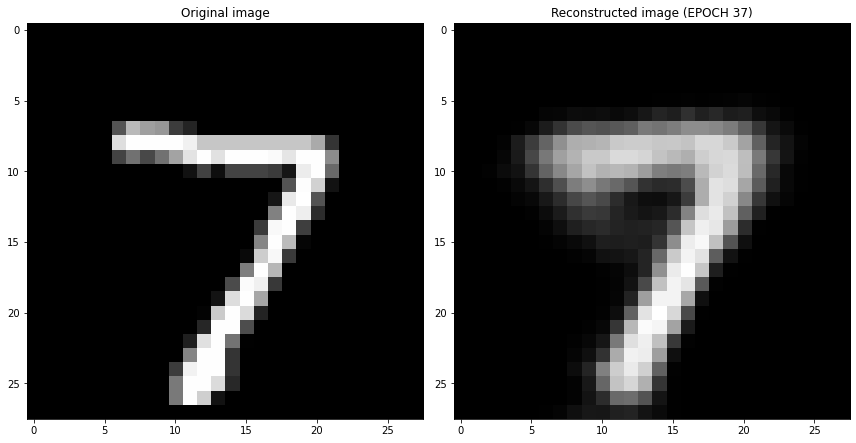

EPOCH 38/40
	 partial train loss (single batch): 0.036677
	 partial train loss (single batch): 0.037723
	 partial train loss (single batch): 0.039480
	 partial train loss (single batch): 0.038391
	 partial train loss (single batch): 0.037910
	 partial train loss (single batch): 0.037383
	 partial train loss (single batch): 0.037970
	 partial train loss (single batch): 0.039539
	 partial train loss (single batch): 0.038629
	 partial train loss (single batch): 0.037079
	 partial train loss (single batch): 0.038534
	 partial train loss (single batch): 0.038147
	 partial train loss (single batch): 0.039248
	 partial train loss (single batch): 0.037513
	 partial train loss (single batch): 0.036900
	 partial train loss (single batch): 0.039049
	 partial train loss (single batch): 0.038035
	 partial train loss (single batch): 0.036968
	 partial train loss (single batch): 0.037684
	 partial train loss (single batch): 0.036976
	 partial train loss (single batch): 0.038568
	 partial train loss (

	 partial train loss (single batch): 0.038148
	 partial train loss (single batch): 0.037374
	 partial train loss (single batch): 0.038174
	 partial train loss (single batch): 0.038319
	 partial train loss (single batch): 0.037525
	 partial train loss (single batch): 0.038319
	 partial train loss (single batch): 0.038562
	 partial train loss (single batch): 0.036490
	 partial train loss (single batch): 0.036803
	 partial train loss (single batch): 0.037245
	 partial train loss (single batch): 0.038164
	 partial train loss (single batch): 0.038330
	 partial train loss (single batch): 0.036398
	 partial train loss (single batch): 0.038988
	 partial train loss (single batch): 0.038251
	 partial train loss (single batch): 0.036999
	 partial train loss (single batch): 0.037355
	 partial train loss (single batch): 0.036881
	 partial train loss (single batch): 0.038054
	 partial train loss (single batch): 0.037575
	 partial train loss (single batch): 0.035792
	 partial train loss (single batch

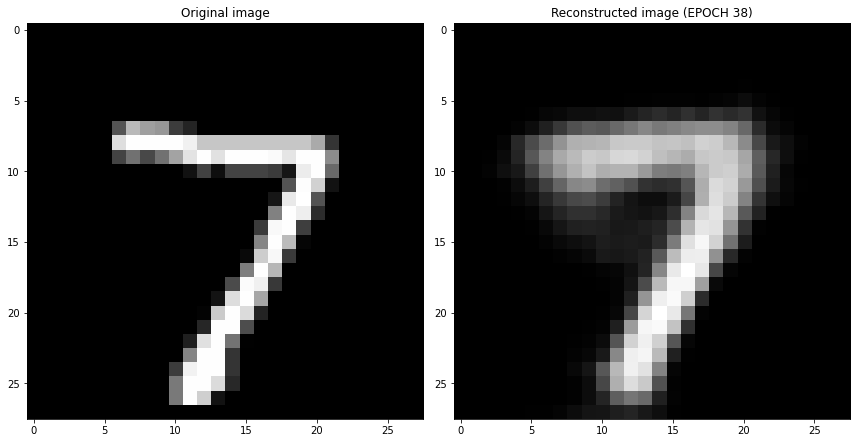

EPOCH 39/40
	 partial train loss (single batch): 0.037619
	 partial train loss (single batch): 0.038630
	 partial train loss (single batch): 0.038559
	 partial train loss (single batch): 0.035638
	 partial train loss (single batch): 0.038426
	 partial train loss (single batch): 0.039308
	 partial train loss (single batch): 0.037785
	 partial train loss (single batch): 0.038478
	 partial train loss (single batch): 0.038336
	 partial train loss (single batch): 0.040486
	 partial train loss (single batch): 0.037562
	 partial train loss (single batch): 0.036061
	 partial train loss (single batch): 0.038459
	 partial train loss (single batch): 0.037201
	 partial train loss (single batch): 0.040349
	 partial train loss (single batch): 0.037360
	 partial train loss (single batch): 0.039165
	 partial train loss (single batch): 0.037416
	 partial train loss (single batch): 0.039077
	 partial train loss (single batch): 0.036691
	 partial train loss (single batch): 0.035913
	 partial train loss (

	 partial train loss (single batch): 0.037645
	 partial train loss (single batch): 0.038505
	 partial train loss (single batch): 0.037345
	 partial train loss (single batch): 0.038458
	 partial train loss (single batch): 0.037843
	 partial train loss (single batch): 0.036567
	 partial train loss (single batch): 0.038477
	 partial train loss (single batch): 0.036179
	 partial train loss (single batch): 0.037147
	 partial train loss (single batch): 0.038042
	 partial train loss (single batch): 0.036724
	 partial train loss (single batch): 0.035557
	 partial train loss (single batch): 0.038581
	 partial train loss (single batch): 0.039377
	 partial train loss (single batch): 0.039998
	 partial train loss (single batch): 0.036801
	 partial train loss (single batch): 0.039072
	 partial train loss (single batch): 0.038432
	 partial train loss (single batch): 0.038429
	 partial train loss (single batch): 0.038823
	 partial train loss (single batch): 0.037221
	 partial train loss (single batch

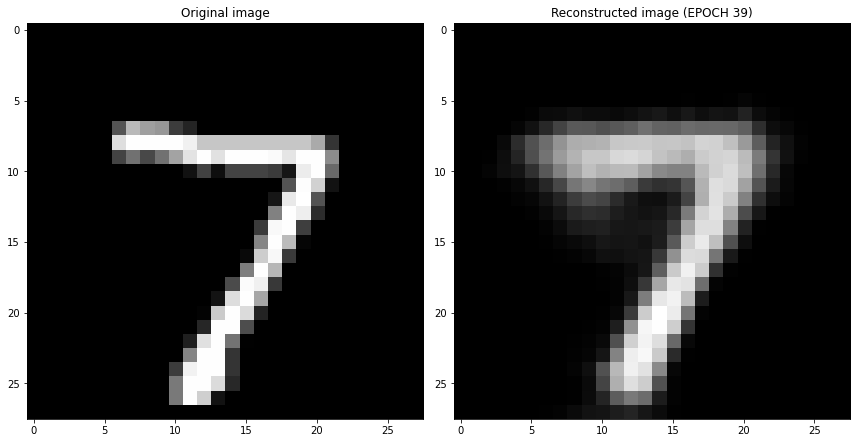

EPOCH 40/40
	 partial train loss (single batch): 0.036609
	 partial train loss (single batch): 0.038127
	 partial train loss (single batch): 0.038618
	 partial train loss (single batch): 0.038478
	 partial train loss (single batch): 0.036534
	 partial train loss (single batch): 0.036438
	 partial train loss (single batch): 0.037448
	 partial train loss (single batch): 0.039161
	 partial train loss (single batch): 0.038230
	 partial train loss (single batch): 0.038397
	 partial train loss (single batch): 0.036178
	 partial train loss (single batch): 0.037034
	 partial train loss (single batch): 0.037052
	 partial train loss (single batch): 0.037720
	 partial train loss (single batch): 0.034985
	 partial train loss (single batch): 0.037034
	 partial train loss (single batch): 0.037480
	 partial train loss (single batch): 0.038202
	 partial train loss (single batch): 0.038364
	 partial train loss (single batch): 0.035785
	 partial train loss (single batch): 0.037786
	 partial train loss (

	 partial train loss (single batch): 0.036528
	 partial train loss (single batch): 0.038873
	 partial train loss (single batch): 0.039279
	 partial train loss (single batch): 0.039519
	 partial train loss (single batch): 0.040070
	 partial train loss (single batch): 0.037968
	 partial train loss (single batch): 0.037942
	 partial train loss (single batch): 0.037816
	 partial train loss (single batch): 0.037356
	 partial train loss (single batch): 0.038854
	 partial train loss (single batch): 0.036950
	 partial train loss (single batch): 0.037445
	 partial train loss (single batch): 0.036735
	 partial train loss (single batch): 0.039393
	 partial train loss (single batch): 0.037842
	 partial train loss (single batch): 0.038528
	 partial train loss (single batch): 0.035404
	 partial train loss (single batch): 0.036040
	 partial train loss (single batch): 0.038371
	 partial train loss (single batch): 0.039579
	 partial train loss (single batch): 0.038797
	 partial train loss (single batch

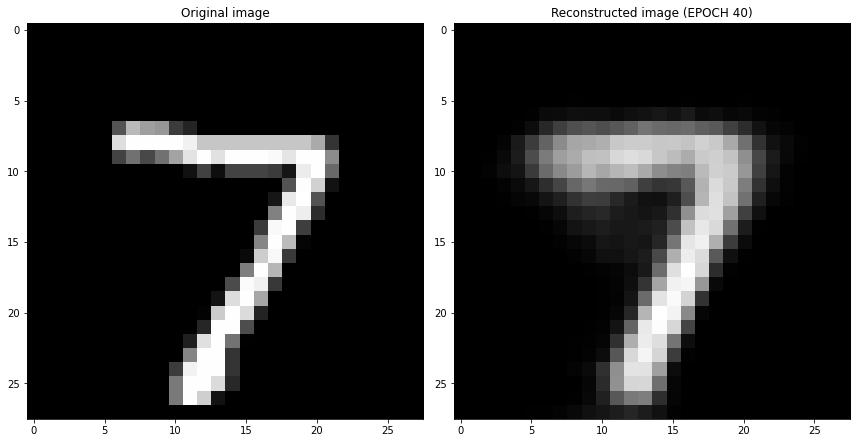

In [14]:
### Training cycle
num_epochs = 40
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')
    torch.save(optim.state_dict(), 'optim_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [ ]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [15]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1044.58it/s]


For convenience (not required), convert the result to a table format (`pandas.DataFrame`):

In [16]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,-12.964681,1.147492,7
1,-1.189397,-0.250439,2
2,-21.260973,-32.731937,1
3,3.814410,7.103825,0
4,-7.281645,3.752739,4
...,...,...,...
9995,-0.661769,-0.371636,2
9996,-1.648487,-1.239535,3
9997,-20.749456,7.345479,4
9998,17.489330,-16.800100,5


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [17]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

ModuleNotFoundError: No module named 'plotly'

As you can see from the graph, even if we never used the labels (i.e. the actual digit written in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Princiapal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

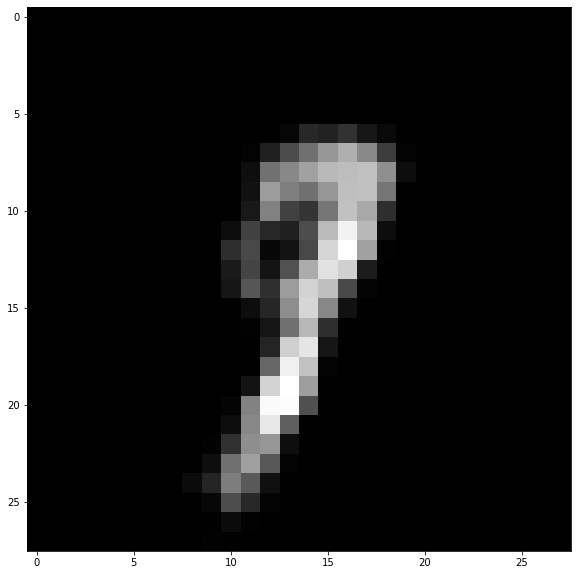

In [18]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-40, -10.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()